In [7]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))




In [8]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import json
import pickle
import ast
import scipy

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()
    
def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def process_awake_data_return_seq_dfs(unmasked_spikes_df,chunk_time,file_path,awake_neuron_order,colors):

    seqs = np.unique(unmasked_spikes_df.sequence_type_adjusted)
    seq_spikes = []
    for seq_type_ in seqs:  
        seq_spikes += [unmasked_spikes_df.timestamp[np.where(unmasked_spikes_df.sequence_type_adjusted ==seq_type_)[0]].values]

    # Define the bin size (in this case, 0.2s)
    bin_size = 0.2

    seq_spike_occurance = []
    for spikes_ in seq_spikes:
        # Use the numpy.histogram function to bin the data
        hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(chunk_time)[0], bin_size))
        seq_spike_occurance += [list(hist)]

    seq_size_threshold= 5

    seq_event_dfs = []
    for i in range(1,7):
        print(i)

        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)

        ### plot to check that I am accounting ofr sequences properly

        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

        fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, awake_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
        ax2.plot(seq_spike_count, color = colors[i])
        for item in groups:
            ax2.plot(item,[-5,-5], color = 'red')

        ax1.set_xlim([0,100])
        ax2.set_xlim([0,(100/bin_size)])

        for group in groups:

            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                seq_event_dfs += [unmasked_spikes_df[mask][seq_mask]]
                
    #### save out      
    with open(file_path, 'wb') as file:
        pickle.dump(seq_event_dfs, file)
        
    return(seq_event_dfs)

def awake_seqs_find_neuron_time_occurances(awake_seq_event_dfs,seq_type):
    neuron_time_occurances = {}
    # loop across awake seq events
    for index,awake_seq in enumerate(awake_seq_event_dfs):
        if awake_seq.sequence_type.values[0] == seq_type:
            # determine relative spiek times
            relataive_ts = awake_seq.timestamp-min(awake_seq.timestamp)
            max_ts = max(relataive_ts)

            # loop across each neuron in the seq and save this data out 
            for neuron_id in awake_seq.neuron.unique():
                mask = awake_seq.neuron == neuron_id
                #mask by neuron id and determine when it occured - in relative time 
                proportional_event_time_occurance = relataive_ts[mask].values/max_ts
                if neuron_id not in neuron_time_occurances:
                    neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
                else:
                    neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

def sleep_seqs_find_neuron_time_occurances(replay_motif_data,seq_type):

    neuron_time_occurances ={}
    seq_type_replay_motif_data = replay_motif_data[replay_motif_data.cluster_seq_type == seq_type]
    for index, spike_times in enumerate(seq_type_replay_motif_data.cluster_spike_times):
        spike_times = np.array(ast.literal_eval(spike_times))
        cluser_ids = ast.literal_eval(seq_type_replay_motif_data.cluster_neurons[index])

        # determine relative spiek times
        relataive_ts = spike_times-min(spike_times)
        max_ts = max(relataive_ts)

        # loop across each neuron in the seq and save this data out 
        for neuron_id in np.unique(cluser_ids):
            mask = cluser_ids == neuron_id
            #mask by neuron id and determine when it occured - in relative time 
            proportional_event_time_occurance = relataive_ts[mask]/max_ts
            if neuron_id not in neuron_time_occurances:
                neuron_time_occurances[neuron_id] = list(proportional_event_time_occurance)
            else:
                neuron_time_occurances[neuron_id] += list(proportional_event_time_occurance)
    return neuron_time_occurances

import re

def convert_string_array_to_list(string_array):
    # Extract numeric values (integers, floats, and scientific notation) from the string using regular expression
    numeric_values = re.findall(r'\d+(\.\d+)?(e[-+]?\d+)?|\d+', string_array)

    # Convert the numeric values to appropriate data types and create the list
    array = []
    for num_parts in numeric_values:
        num = ''.join(part for part in num_parts if part)

        if '.' not in num and 'e' not in num and not num == '':
            array.append(int(num))
        elif '.' in num and 'e' not in num:
            array.append(float(num))
        elif num == '':
            array.append(float(0))
        else:
            array.append(float(num))
    
    return array

red = '#BE575F'
blue = '#2093C0'

In [9]:
#### to do: plot all three groups together, or at least two of them, expert vs learning and expert vs h_lesion


In [10]:
# single event temporal sequece analysis: how doe sit relate to latent information. 
# for each event, plot which neurons are involved and what order they occur, see how this matches what we see in awake behaviour.
# load awake behav. filter for each sequence or load in the fset fro the latent analysis. 
# see if the temporal ofsets and neuron types are consitent in rpelay and consistent with awake
# use this to determine reverse and stuff? # save these outsomehwre? # do these correspond properlyh with warp values?

In [11]:
# seq filter takes presedence, if its on: only sequential events, if it is off: all events 
sequential_filter = True
## master switch - turns all sleep filters on/off (if you want all evets turn this off)
sleep_filters_on = True
# these filters refer to seq one above, and both can be true at the same time. 
nrem_filter = True
rem_filter = True
# set this as true (along with the fleep filter one) to override the other two an djust take the background 
background_only = False


## sanity checker / set save path:
print('this filtering gives...')
if sequential_filter == True:
    print(' - only sequential events')
    save_var = 'sequential_no_sleep_selected'
    type_var = 'sequential'
else:
    print('- all events')
    save_var = 'all_events_no_sleep_selected'
    type_var = 'all_events'
if sleep_filters_on == True:
    if not background_only:
        print('but only those which are in')
        if nrem_filter == True:
            print(' - nrem')
            save_var = type_var+'_NREM_sleep'
        if rem_filter == True:
            print(' - rem')
            save_var = type_var+'_REM_sleep'
        if nrem_filter == True and rem_filter == True:
            save_var = type_var+'_NREM_and_REM_sleep'
        
    else:
        print('but only those which are not in rem/nrem')
        save_var = type_var + '_OTHER_nonsleep'
        

this filtering gives...
 - only sequential events
but only those which are in
 - nrem
 - rem


In [12]:
# ignore_list = ['148_2_2','178_1_5','255_1_2','255_1_4','262_1_5','269_1_2','269_1_5','269_1_6','270_1_1']
ignore_list = ['269_1_5','269_1_6','270_1_1','178_2_3']

analysis_folder = r'\\_final_analysis_output\\'

# save path
out_path = r'Z:\projects\Emmett\Documents\replay_paper\new_replay_analysis\FINAL\\' + save_var + '\\' 

# dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\striatum\New_Post_sleep\\"
dat_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\paper_submission\post_sleep\\"

sleep_time_point_df = pd.read_csv(dat_path + 'sleep_time_points.csv')

sleep_start = {}
for index,value in enumerate(sleep_time_point_df.approx_sleep_start.values):
    mouse = sleep_time_point_df.mir.values[index]
    sleep_start[mouse] = value

expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values
hlesion_mice = sleep_time_point_df[sleep_time_point_df.group == 'h_lesion'].mir.values
learning_mice = sleep_time_point_df[sleep_time_point_df.group == 'learning'].mir.values

mirs = []
all_motif_involvements_df =  pd.DataFrame({'motif_involvements_awake':[],'motif_involvements_sleep':[],'mouse':[]})
task_motif_involvements_df =  pd.DataFrame({'task_motif_involvements_awake':[],'task_motif_involvements_sleep':[],'mouse':[]})
nontask_motif_involvements_df =  pd.DataFrame({'nontask_motif_involvements_awake':[],'nontask_motif_involvements_sleep':[],'mouse':[]})
reward_related_all_motif_involvements_df =  pd.DataFrame({'reward_related_motif_involvements_awake':[],'reward_related_motif_involvements_sleep':[],'mouse':[]})
reward_related_task_motif_involvements_df =  pd.DataFrame({'reward_related_task_motif_involvements_awake':[],'reward_related_task_motif_involvements_sleep':[],'mouse':[]})
reward_related_nontask_motif_involvements_df =  pd.DataFrame({'reward_related_nontask_motif_involvements_awake':[],'reward_related_nontask_motif_involvements_sleep':[],'mouse':[]})
temporally_ordered_proportions = pd.DataFrame({'seq_type':[],'temporally_ordered':[],'stationary':[],'not_ordered':[],'task_involved':[],'mouse':[]})
regression_df = pd.DataFrame({'seq_type':[],'regression_line':[],'filt_rel_spike_times':[],'slope':[],'reactivation_ID':[],'warp_factor':[],'mouse':[],'sleep_onset_diff':[]})
start_end_df = pd.DataFrame({})


e_awake_sleep_relationship = {}
e_task_awake_sleep_relationship = {}
e_non_task_awake_sleep_relationship = {}

hl_awake_sleep_relationship = {}
hl_task_awake_sleep_relationship = {}
hl_non_task_awake_sleep_relationship = {}

l_awake_sleep_relationship = {}
l_task_awake_sleep_relationship = {}
l_non_task_awake_sleep_relationship = {}

e_awake_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
e_awake_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
e_awake_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}

hl_awake_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
hl_awake_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
hl_awake_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}

l_awake_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
l_awake_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
l_awake_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}

e_sleep_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
e_sleep_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
e_sleep_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}

hl_sleep_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
hl_sleep_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
hl_sleep_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}

l_sleep_rich_neuron_involvement_data = {key: [] for key in range(1, 7)}
l_sleep_rich_neuron_involvement_data_task_only = {key: [] for key in range(1, 7)}
l_sleep_rich_neuron_involvement_data_non_task = {key: [] for key in range(1, 7)}




for run_index,pp_file in enumerate(os.listdir(dat_path)):
    print(run_index)
    if not 'sleep_time_points' in pp_file:
        mouse = '_'.join(pp_file.split('_')[0:3])
        
        if not mouse in ignore_list:
            if mouse in list(expert_mice) + list(hlesion_mice) + list(learning_mice):

                current_mouse_path = dat_path + pp_file + analysis_folder
                mirs += ['_'.join(pp_file.split('_')[0:3])]
                for file in os.listdir(current_mouse_path):
                    if 'chunk' in file:
                        print(mouse)
                        current_sleep_start = sleep_start[mouse]
                        current_data_path = current_mouse_path + '\\' + file + '\\'
                        chunk_time = np.load(current_data_path + 'chunk_time_interval.npy')

                        sleep_onset_diff = np.mean(chunk_time) - current_sleep_start

                        current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'

    #                     try:
    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'all_motif_involvements.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     all_motif_involvements_df = pd.concat((all_motif_involvements_df,df_load),axis =0)
    #                     all_motif_involvements_df.reset_index(drop = True)

    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'task_motif_involvements.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     task_motif_involvements_df = pd.concat((task_motif_involvements_df,df_load),axis =0)
    #                     task_motif_involvements_df.reset_index(drop = True)

    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'nontask_motif_involvements.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     nontask_motif_involvements_df = pd.concat((nontask_motif_involvements_df,df_load),axis =0)
    #                     nontask_motif_involvements_df.reset_index(drop = True)

    #                     ## same again but for reward
    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'reward_related_motif_involvements_awake.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     reward_related_all_motif_involvements_df = pd.concat((reward_related_all_motif_involvements_df,df_load),axis =0)
    #                     reward_related_all_motif_involvements_df.reset_index(drop = True)

    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'reward_related_task_motif_involvements.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     reward_related_task_motif_involvements_df = pd.concat((reward_related_task_motif_involvements_df,df_load),axis =0)
    #                     reward_related_task_motif_involvements_df.reset_index(drop = True)

    #                     df_load = pd.read_csv(current_data_path_temporal_structre+'reward_related_nontask_motif_involvements.csv',index_col=0)
    #                     df_load['mouse'] = [mouse]*len(df_load)
    #                     reward_related_nontask_motif_involvements_df = pd.concat((reward_related_nontask_motif_involvements_df,df_load),axis =0)
    #                     reward_related_nontask_motif_involvements_df.reset_index(drop = True)

                        ####load in temporal order props
                        df_load = pd.read_csv(current_data_path_temporal_structre+'temporally_ordered_proportions.csv',index_col=0)
                        df_load['mouse'] = [mouse]*len(df_load)
                        temporally_ordered_proportions = pd.concat((temporally_ordered_proportions,df_load),axis =0)
                        temporally_ordered_proportions.reset_index(drop = True)

                        try:

                            ### start stop points
                            df_load = pd.read_csv(current_data_path_temporal_structre+'start_end_df.csv',index_col=0)
                            df_load['mouse'] = [mouse]*len(df_load)
                            df_load['sleep_onset_diff'] = [sleep_onset_diff]*len(df_load)
                            start_end_df = pd.concat((start_end_df,df_load),axis =0)
                            start_end_df.reset_index(drop = True)

                        except:
                            print('no start stops points available')

                        ###
                        replay_motif_data= pd.read_csv(current_data_path+'filtered_replay_clusters_df.csv',index_col=0)

                        ## load awake data
                        awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
                        for file_ in os.listdir(awake_PP_path):
                            if mouse in file_:
                                awake_file = file_
                        #### load in awake task data dn determine awake sequence ordering:
                        with open(awake_PP_path + awake_file + r'\analysis_output\\' + 'spikes_seq_type_adjusted.pickle', 'rb') as handle:
                            unmasked_spikes_df = pickle.load(handle)


                        file_path = current_data_path_temporal_structre + 'awake_seq_event_dfs.pkl'
                        with open(file_path, 'rb') as file:
                            awake_seq_event_dfs = pickle.load(file)
                            print('loading')


                        ######## NEURON INVOLVEMENT ANALYSIS #########################################################################################################################

                        data = pd.read_csv(current_data_path + 'filtered_replay_clusters_df.csv')

                        ## filter this data
                        if sequential_filter == True: 
                            sequential_condition = data.ordering_classification == 'sequential'
                        else:
                            sequential_condition = np.array([True]*len(data.ordering_classification))

                        if sleep_filters_on == True:
                            if nrem_filter == True: 
                                nrem_condition = nrem__condition = data.nrem_events == 1
                            else:
                                nrem_condition = np.array([False]*len(data.nrem_events))

                            if rem_filter == True: 
                                rem_condition = rem__condition = data.rem_events == 1
                            else:
                                rem_condition = np.array([False]*len(data.rem_events))

                            if background_only == True:
                                rem_condition = rem__condition = data.rem_events == 0
                                nrem_condition = nrem__condition = data.nrem_events == 1

                        else:
                            nrem_condition = np.array([True]*len(data))
                            rem_condition = np.array([True]*len(data))

                        # filter is set up so that any true will carry forward 
                        filter_mask = sequential_condition * (nrem_condition + rem_condition)

                        filtered_chunk_data = data[filter_mask].reset_index()
                        
                        
                        # load in regression dfs
                        df_load = pd.read_csv(current_data_path_temporal_structre+'regression_df.csv',index_col=0)
                        df_load['mouse'] = [mouse]*len(df_load)
                        df_load['sleep_onset_diff'] = [sleep_onset_diff]*len(df_load)
                        
                        # mask it by the filtering settings 
                        masked_df = df_load[df_load['reactivation_ID'].isin(data[filter_mask].index.values)]
                        regression_df = pd.concat((regression_df,masked_df),axis =0)
                        regression_df.reset_index(drop = True)


                        ### determine which neurons are involved in awake seqs
                        all_neurons_list = list(np.unique(unmasked_spikes_df.neuron))

                        for seq_type in range(1,7):
                            print(seq_type)

                            # Determine mean neuron involvements for awake
                            neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
                            for awake_seq in awake_seq_event_dfs:
                                if awake_seq.sequence_type_adjusted.values[0] == seq_type:
                                    for id_, neuron_id in enumerate(all_neurons_list):
                                        if neuron_id in awake_seq.neuron.values:
                                            neuron_motif_involvements[id_].append(1)
                                        else:
                                            neuron_motif_involvements[id_].append(0)
                            #find mean involvements:
                            awake_mean_neuron_motif_involvements = []
                            for item in neuron_motif_involvements:
                                if len(item)>0:
                                    awake_mean_neuron_motif_involvements += [sum(item)/len(item)]
                                else:
                                    awake_mean_neuron_motif_involvements += [0]

                            # Determine mean neuron involvements for sleep
                            neuron_motif_involvements = [[] for _ in range(len(all_neurons_list))]
                            for index in range(len(filtered_chunk_data)):
                                if filtered_chunk_data.cluster_seq_type[index] == seq_type:
                                    for id_, neuron_id in enumerate(all_neurons_list):
                                        if neuron_id in ast.literal_eval(filtered_chunk_data.cluster_neurons[index]):
                                            neuron_motif_involvements[id_].append(1)
                                        else:
                                            neuron_motif_involvements[id_].append(0)
                                            
                            # min number of sequences seen: 
                            min_seqs_seen = 0
                            
                            #find mean involvements:
                            sleep_mean_neuron_motif_involvements = []
                            for item in neuron_motif_involvements:
                                if len(item)>min_seqs_seen:
                                    sleep_mean_neuron_motif_involvements += [sum(item)/len(item)]
                                else:
                                    sleep_mean_neuron_motif_involvements += [0]

                            # minimum number of neurons
                            min_neurons_filter = 5

                            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]    
                            if mouse in expert_mice:
                                for bin_ in bins:
                                    mask = np.round(awake_mean_neuron_motif_involvements,1) == bin_
                                    if len(np.array(sleep_mean_neuron_motif_involvements)[mask]) > min_neurons_filter:
                                        if bin_ in e_awake_sleep_relationship:
                                            e_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                        else:
                                            e_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                            if bin_ in e_task_awake_sleep_relationship:
                                                e_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                e_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        else:
                                            if bin_ in e_non_task_awake_sleep_relationship:
                                                e_non_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                e_non_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]


                            elif mouse in hlesion_mice:
                                for bin_ in bins:
                                    mask = np.round(awake_mean_neuron_motif_involvements,1) == bin_
                                    if len(np.array(sleep_mean_neuron_motif_involvements)[mask]) > min_neurons_filter:
                                        if bin_ in hl_awake_sleep_relationship:
                                            hl_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                        else:
                                            hl_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                            if bin_ in hl_task_awake_sleep_relationship:
                                                hl_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                hl_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        else:
                                            if bin_ in hl_non_task_awake_sleep_relationship:
                                                hl_non_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                hl_non_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                            elif mouse in learning_mice:
                                for bin_ in bins:
                                    mask = np.round(awake_mean_neuron_motif_involvements,1) == bin_
                                    if len(np.array(sleep_mean_neuron_motif_involvements)[mask]) > min_neurons_filter:
                                        if bin_ in l_awake_sleep_relationship:
                                            l_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                        else:
                                            l_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                            if bin_ in l_task_awake_sleep_relationship:
                                                l_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                l_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]

                                        else:
                                            if bin_ in l_non_task_awake_sleep_relationship:
                                                l_non_task_awake_sleep_relationship[bin_] += [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                            else:
                                                l_non_task_awake_sleep_relationship[bin_] = [np.mean(np.array(sleep_mean_neuron_motif_involvements)[mask])]
                                                
                                                
                            if mouse in expert_mice:
                                e_sleep_rich_neuron_involvement_data[seq_type] += [sleep_mean_neuron_motif_involvements]
                                e_awake_rich_neuron_involvement_data[seq_type] += [awake_mean_neuron_motif_involvements]
                                if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                    e_awake_rich_neuron_involvement_data_task_only[seq_type] += [awake_mean_neuron_motif_involvements]
                                    e_sleep_rich_neuron_involvement_data_task_only[seq_type] += [sleep_mean_neuron_motif_involvements]
                                else:
                                    e_awake_rich_neuron_involvement_data_non_task[seq_type] += [awake_mean_neuron_motif_involvements]
                                    e_sleep_rich_neuron_involvement_data_non_task[seq_type] += [sleep_mean_neuron_motif_involvements]

                            elif mouse in hlesion_mice:
                                hl_sleep_rich_neuron_involvement_data[seq_type] += [sleep_mean_neuron_motif_involvements]
                                hl_awake_rich_neuron_involvement_data[seq_type] += [awake_mean_neuron_motif_involvements]
                                if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                    hl_awake_rich_neuron_involvement_data_task_only[seq_type] += [awake_mean_neuron_motif_involvements]
                                    hl_sleep_rich_neuron_involvement_data_task_only[seq_type] += [sleep_mean_neuron_motif_involvements]
                                else:
                                    hl_awake_rich_neuron_involvement_data_non_task[seq_type] += [awake_mean_neuron_motif_involvements]
                                    hl_sleep_rich_neuron_involvement_data_non_task[seq_type] += [sleep_mean_neuron_motif_involvements]

                            elif mouse in learning_mice:
                                l_sleep_rich_neuron_involvement_data[seq_type] += [sleep_mean_neuron_motif_involvements]
                                l_awake_rich_neuron_involvement_data[seq_type] += [awake_mean_neuron_motif_involvements]
                                if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
                                    l_awake_rich_neuron_involvement_data_task_only[seq_type] += [awake_mean_neuron_motif_involvements]
                                    l_sleep_rich_neuron_involvement_data_task_only[seq_type] += [sleep_mean_neuron_motif_involvements]
                                else:
                                    l_awake_rich_neuron_involvement_data_non_task[seq_type] += [awake_mean_neuron_motif_involvements]
                                    l_sleep_rich_neuron_involvement_data_non_task[seq_type] += [sleep_mean_neuron_motif_involvements]
                                    
    
                                


    #                     except:
    #                         print('error')



                        
                        
            

0
136_1_3
loading
1
2
3
4
5
6
136_1_3
loading
1
2
3
4
5
6
136_1_3
loading
1
2
3
4
5
6
1
136_1_4
loading
1
2
3
4
5
6
136_1_4
loading
1
2
3
4
5
6
136_1_4
loading
1
2
3
4
5
6
2
148_2_2
loading
1
2
3
4
5
6
148_2_2
loading
1
2
3
4
5
6
148_2_2
loading
1
2
3
4
5
6
3
149_1_1
loading
1
2
3
4
5
6
149_1_1
loading
1
2
3
4
5
6
149_1_1
loading
1
2
3
4
5
6
4
178_1_4
loading
1
2
3
4
5
6
178_1_4
loading
1
2
3
4
5
6
178_1_4
loading
1
2
3
4
5
6
5
178_1_5
loading
1
2
3
4
5
6
178_1_5
loading
1
2
3
4
5
6
178_1_5
loading
1
2
3
4
5
6
6
178_1_6
loading
1
2
3
4
5
6
178_1_6
loading
1
2
3
4
5
6
178_1_6
loading
1
2
3
4
5
6
7
178_1_7
loading
1
2
3
4
5
6
178_1_7
loading
1
2
3
4
5
6
178_1_7
loading
1
2
3
4
5
6
8
178_1_8
loading
1
2
3
4
5
6
178_1_8
loading
1
2
3
4
5
6
178_1_8
loading
1
2
3
4
5
6
9
178_1_9
loading
1
2
3
4
5
6
178_1_9
loading
1
2
3
4
5
6
178_1_9
loading
1
2
3
4
5
6
10
178_2_1
loading
1
2
3
4
5
6
178_2_1
loading
1
2
3
4
5
6
178_2_1
loading
1
2
3
4
5
6
11
178_2_2
loading
1
2
3
4
5
6
178_2_2
loading
1
2
3


In [13]:
neuron_rel_awake_positions_reverse = []
neuron_rel_reverse_replay_positions = []

neuron_rel_awake_positions_forwards = []
neuron_rel_forward_replay_positions = []

expert_bool = []
hlesion_bool = []
learning_bool = []

for run_index,pp_file in enumerate(os.listdir(dat_path)):
    print(run_index)
    if not 'sleep_time_points' in pp_file:
        mouse = '_'.join(pp_file.split('_')[0:3])
        if not mouse in ignore_list:
            if mouse in list(expert_mice) + list(hlesion_mice) + list(learning_mice):
                current_mouse_path = dat_path + pp_file + analysis_folder
                for file in os.listdir(current_mouse_path):
                    mouse_neuron_rel_awake_positions_reverse = []
                    mouse_neuron_rel_reverse_replay_positions = []
                    mouse_neuron_rel_awake_positions_forwards = []
                    mouse_neuron_rel_forward_replay_positions = []
                    if 'chunk' in file:
                        print(mouse)
                        current_data_path = current_mouse_path + '\\' + file + '\\'

                        current_data_path_temporal_structre = current_data_path + 'temporal_structure_analysis\\'

                        mouse_neuron_rel_awake_positions_reverse += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_reverse.npy'))
                        mouse_neuron_rel_reverse_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_reverse_replay_positions.npy'))
                        mouse_neuron_rel_awake_positions_forwards += list(np.load(current_data_path_temporal_structre + 'neuron_rel_awake_positions_forwards.npy'))
                        mouse_neuron_rel_forward_replay_positions += list(np.load(current_data_path_temporal_structre + 'neuron_rel_forward_replay_positions.npy'))
                        
                    if mouse in expert_mice:
                        expert_bool += [1]
                    else:
                        expert_bool +=[0]
                    if mouse in hlesion_mice:
                        hlesion_bool += [1]
                    else:
                        hlesion_bool +=[0]
                    if mouse in learning_mice:
                        learning_bool += [1]
                    else:
                        learning_bool +=[0]
                            
                    neuron_rel_awake_positions_reverse += [mouse_neuron_rel_awake_positions_reverse]
                    neuron_rel_reverse_replay_positions += [mouse_neuron_rel_reverse_replay_positions]
                    neuron_rel_awake_positions_forwards += [mouse_neuron_rel_awake_positions_forwards]
                    neuron_rel_forward_replay_positions += [mouse_neuron_rel_forward_replay_positions]

0
136_1_3
136_1_3
136_1_3
1
136_1_4
136_1_4
136_1_4
2
148_2_2
148_2_2
148_2_2
3
149_1_1
149_1_1
149_1_1
4
178_1_4
178_1_4
178_1_4
5
178_1_5
178_1_5
178_1_5
6
178_1_6
178_1_6
178_1_6
7
178_1_7
178_1_7
178_1_7
8
178_1_8
178_1_8
178_1_8
9
178_1_9
178_1_9
178_1_9
10
178_2_1
178_2_1
178_2_1
11
178_2_2
178_2_2
178_2_2
12
13
178_2_4
178_2_4
178_2_4
178_2_4
14
15
16
17
255_1_1
255_1_1
255_1_1
18
255_1_2
255_1_2
255_1_2
19
255_1_4
255_1_4
255_1_4
20
256_1_1
256_1_1
256_1_1
21
262_1_1
262_1_1
262_1_1
22
262_1_2
262_1_2
262_1_2
23
262_1_4
262_1_4
262_1_4
24
262_1_5
262_1_5
262_1_5
25
262_1_6
262_1_6
262_1_6
26
268_1_2
268_1_2
268_1_2
27
269_1_1
269_1_1
269_1_1
28
269_1_2
269_1_2
269_1_2
29
269_1_3
269_1_3
269_1_3
30
269_1_4
269_1_4
269_1_4
31
32
33
269_1_7
269_1_7
269_1_7
34
35
270_1_3
270_1_3
270_1_3
36
270_1_5
270_1_5
270_1_5
37
270_1_6
270_1_6
270_1_6
38


In [14]:
from scipy import stats
def bin_data(x, y, n_bins):
   # Create bins for y values
    bin_edges = np.linspace(0, 1, n_bins)
    
    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Assign each data point to the closest bin
    bin_indices = np.argmin(np.abs(np.subtract.outer(y, bin_centers)), axis=1)
    
    # Initialize arrays to store binned data
    binned_x = [[] for _ in range(n_bins)]
    
    # Populate binned arrays
    for i in range(len(y)):
        bin_idx = bin_indices[i]
        binned_x[bin_idx].append(x[i])
    
    # Calculate mean and SEM for each bin
    bin_means = np.array([np.mean(b) for b in binned_x])
    bin_sems = np.array([np.std(b) for b in binned_x])
    
    return bin_means, bin_sems,bin_edges,binned_x

C:\Users\Emmett\AppData\Local\Temp\ipykernel_16660\3172572566.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(neuron_rel_reverse_replay_positions)[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_16660\3172572566.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(neuron_rel_awake_positions_reverse)[np.array(bool_) == 1]


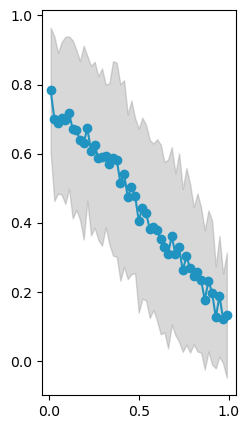

In [15]:
import numpy as np
import pandas as pd

bool_ = expert_bool
# bool_ = hlesion_bool
# bool_ = learning_bool




# Example XY scatter data (replace this with your actual data)
x = np.array(neuron_rel_reverse_replay_positions)[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(neuron_rel_awake_positions_reverse)[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

# Create a pandas DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Define bin edges for y-values
bin_edges = np.linspace(0, 1, num=50)  # 5 bins from 0 to 1

# Bin the data based on y-values
df['bin'] = pd.cut(df['y'], bins=bin_edges)

# Calculate the middle points of the bins
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation of each bin
bin_means = df.groupby('bin')['x'].mean()
bin_std = df.groupby('bin')['x'].std()

# Plot
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))
ax.plot(bin_midpoints,bin_means,'o-', c = blue)
# plt.plot(bin_midpoints, bin_means, width=0.1, align='center', label='Mean')

# Fill between mean line +- standard deviation
plt.fill_between(bin_midpoints, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.3)
SaveFig(mouse+ 'new_order.pdf',r'D:\\')

C:\Users\Emmett\AppData\Local\Temp\ipykernel_17204\3782750737.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(neuron_rel_forward_replay_positions)[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_17204\3782750737.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(neuron_rel_awake_positions_forwards)[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_17204\3782750737.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-

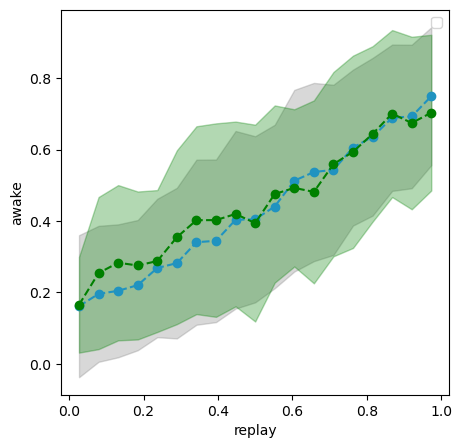

In [14]:
import numpy as np
import pandas as pd

bool_ = expert_bool
# bool_ = hlesion_bool
# bool_ = learning_bool

# Example XY scatter data (replace this with your actual data)
x = np.array(neuron_rel_forward_replay_positions)[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(neuron_rel_awake_positions_forwards)[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

# Create a pandas DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Define bin edges for y-values
bin_edges = np.linspace(0, 1, num=20)  # 5 bins from 0 to 1

# Bin the data based on y-values
df['bin'] = pd.cut(df['y'], bins=bin_edges)

# Calculate the middle points of the bins
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the mean and standard deviation of each bin
bin_means = df.groupby('bin')['x'].mean()
bin_std = df.groupby('bin')['x'].std()

# Plot
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
ax.plot(bin_midpoints,bin_means,'o--', c = blue)
# plt.plot(bin_midpoints, bin_means, width=0.1, align='center', label='Mean')

# Fill between mean line +- standard deviation
plt.fill_between(bin_midpoints, bin_means - bin_std, bin_means + bin_std, color='gray', alpha=0.3)

############################## PLOT 2

# bool_ = expert_bool
bool_ = hlesion_bool
# bool_ = learning_bool

# Example XY scatter data (replace this with your actual data)
x2 = np.array(neuron_rel_forward_replay_positions)[np.array(bool_) == 1]
x2 = [item for sublist in x2 for item in sublist]
y2 = np.array(neuron_rel_awake_positions_forwards)[np.array(bool_) == 1]
y2 = [item for sublist in y2 for item in sublist]

# Create a pandas DataFrame
df2 = pd.DataFrame({'x': x2, 'y': y2})

# Define bin edges for y-values
bin_edges2 = np.linspace(0, 1, num=20)  # 5 bins from 0 to 1

# Bin the data based on y-values
df2['bin'] = pd.cut(df2['y'], bins=bin_edges2)

# Calculate the middle points of the bins
bin_midpoints2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2

# Calculate the mean and standard deviation of each bin
bin_means2 = df2.groupby('bin')['x'].mean()
bin_std2 = df2.groupby('bin')['x'].std()

# Plot

ax.plot(bin_midpoints2,bin_means2,'o--', c = 'green')
# plt.plot(bin_midpoints, bin_means, width=0.1, align='center', label='Mean')

# Fill between mean line +- standard deviation
plt.fill_between(bin_midpoints2, bin_means2 - bin_std2, bin_means2 + bin_std2, color='green', alpha=0.3)



plt.xlabel('replay')
plt.ylabel('awake')
plt.legend()
plt.show()

In [15]:
x = bin_means.values
y = bin_midpoints
x2 = bin_means2.values
y2 = bin_midpoints2

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

A = pd.DataFrame({'x': x,
                  'y': y})
B = pd.DataFrame({'x': x2,
                  'y': y2})
# Combine the data into one DataFrame
data = pd.concat([A, B], axis=0)

# Create a grouping variable
groups = np.array(['A'] * len(x) + ['B'] * len(x2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value  Num DF  Den DF F Value  Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0597 2.0000 35.0000 275.7862 0.0000
         Pillai's trace  0.9403 2.0000 35.0000 275.7862 0.0000
 Hotelling-Lawley trace 15.7592 2.0000 35.0000 275.7862 0.0000
    Roy's greatest root 15.7592 2.0000 35.0000 275.7862 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
           groups         Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.9020 2.0000 35.0000  1.9013 0.1645
           Pillai's trace 0.0980 2.0000 35.0000  1.9013 0.1645
   Hotellin

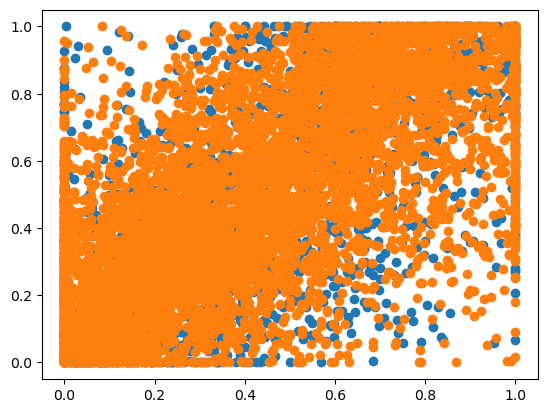

In [559]:
plt.plot(x2,y2,'o')
plt.plot(x,y,'o')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      x   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     1641.
Date:                Mon, 20 May 2024   Prob (F-statistic):               0.00
Time:                        11:20:26   Log-Likelihood:                 686.79
No. Observations:                7502   AIC:                            -1366.
Df Residuals:                    7498   BIC:                            -1338.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.1174      0.006     20.246      0.000       0.106       0.129
C(type)[T.lesion]       0.0631      0.011      5.755      0.000       0.042       0.085
y                       0.6322      0.010     62.091      0.000       0.612       0.652
C(type)[T.lesion]:y    -0.0919      0.019     -4.730      0.000      -0.130      -0.054
==============================================================================
Omnibus:                      165.999   Durbin-Watson:                   1.635
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.399
Skew:                           0.310   Prob(JB):                     1.37e-43
Kurtosis:                       3.498   Cond. No.                         10.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\3595147444.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(neuron_rel_forward_replay_positions)[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\3595147444.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(neuron_rel_awake_positions_forwards)[np.array(bool_) == 1]
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anac

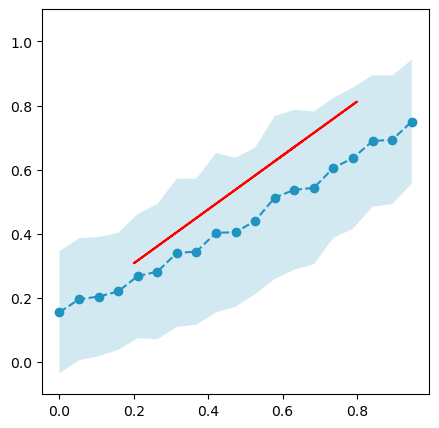

In [511]:
bool_ = expert_bool
# bool_ = hlesion_bool
# bool_ = learning_bool

x = np.array(neuron_rel_forward_replay_positions)[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(neuron_rel_awake_positions_forwards)[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

num_bins = 20
means,sems,bins,binned_x = bin_data(x,y,num_bins)

            
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
ax.plot(bins,means,'o--', c = blue)

upper = np.array(means) + np.array(sems)
lower = np.array(means) - np.array(sems)
ax.fill_between(sorted(bins),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)

plt.plot(x_, intercept + slope*np.array(x_), color='red', label='Linear Fit')

# ax.set_xlim(0,1)
ax.set_ylim(-0.1,1.1)

SaveFig(mouse+ 'forward_awake_v_replay.pdf',r'D:\\')

In [689]:
x_=df.x
y_=df.y

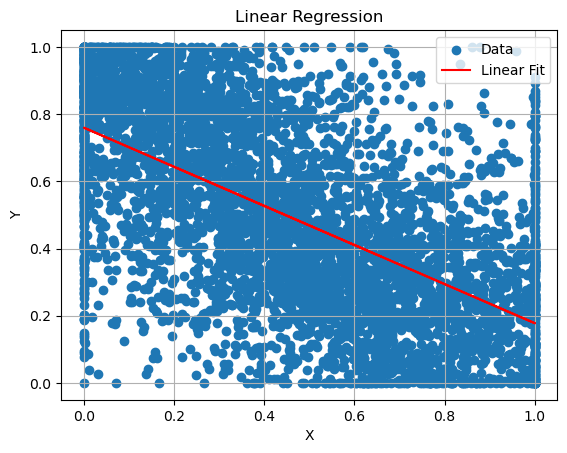

Slope: -0.5818935146545577
Intercept: 0.759544037367633
R-squared: 0.3724456383387708


In [692]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_, y_)

# Plot the data points
plt.scatter(x_, y_, label='Data')

# Plot the regression line
plt.plot(x_, intercept + slope*np.array(x_), color='red', label='Linear Fit')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Linear Regression')
plt.legend()
plt.grid(True)
plt.show()

# Print regression results
print("Slope:", slope)
print("Intercept:", intercept)
print("R-squared:", r_value**2)



In [693]:
p_value

0.0

In [389]:
slope

0.6451544041452444

C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\4048326335.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(neuron_rel_reverse_replay_positions)[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\4048326335.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(neuron_rel_awake_positions_reverse)[np.array(bool_) == 1]
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anaco

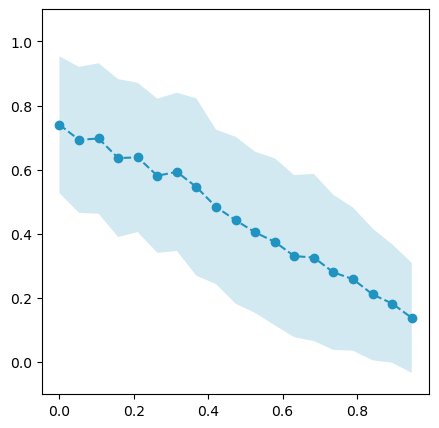

In [382]:
x = np.array(neuron_rel_reverse_replay_positions)[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(neuron_rel_awake_positions_reverse)[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

num_bins = 20
means,sems,bins,binned_x = bin_data(x,y,num_bins)

            
fig, ax = plt.subplots(1, 1,figsize=(5, 5))
ax.plot(bins,means,'o--', c = blue)

upper = np.array(means) + np.array(sems)
lower = np.array(means) - np.array(sems)
ax.fill_between(sorted(bins),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)

ax.set_ylim(-0.1,1.1)

SaveFig(mouse+ 'reverse_awake_v_replay.pdf',r'D:\\')

In [383]:
import statsmodels.api as sm

# Add a constant to the independent variable (for intercept)
X = sm.add_constant(x)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# Get the fitted regression line
predicted_values = model.predict(X)

# Print R-squared and p-values
print("R-squared:", model.rsquared)
print("p-values:", model.pvalues)

R-squared: 0.3724456383387712
p-values: [0. 0.]


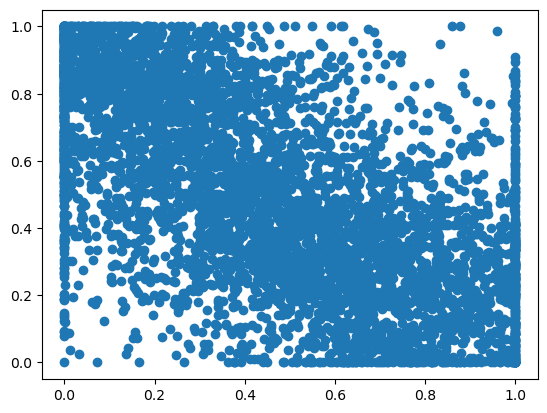

In [378]:
plt.plot(x,y,'o')

C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\552288445.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index,item in enumerate(np.array(neuron_rel_reverse_replay_positions)[np.array(expert_bool) == 1]):
C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\552288445.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(item,np.array(neuron_rel_awake_positions_reverse)[np.array(expert_bool) == 1][index],'o')


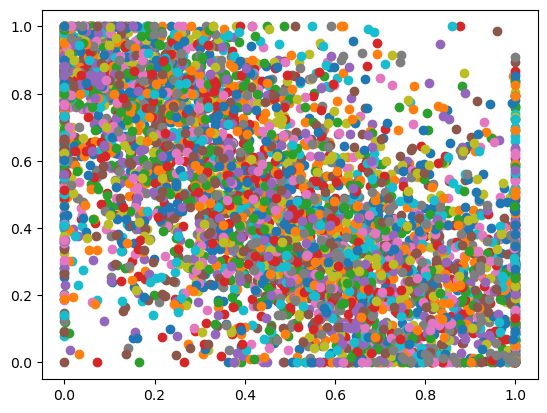

In [188]:
for index,item in enumerate(np.array(neuron_rel_reverse_replay_positions)[np.array(expert_bool) == 1]):
    plt.plot(item,np.array(neuron_rel_awake_positions_reverse)[np.array(expert_bool) == 1][index],'o')
    
# for index,item in enumerate(np.array(neuron_rel_reverse_replay_positions)[np.array(hlesion_bool) == 1]):
#     plt.plot(item,np.array(neuron_rel_awake_positions_reverse)[np.array(hlesion_bool) == 1][index],'o')
    
# for index,item in enumerate(np.array(neuron_rel_reverse_replay_positions)[np.array(learning_bool) == 1]):
#     plt.plot(item,np.array(neuron_rel_awake_positions_reverse)[np.array(learning_bool) == 1][index],'o')

In [ ]:
## bin this and make the plot look nicer


C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\3439427572.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index,item in enumerate(np.array(neuron_rel_forward_replay_positions)[np.array(hlesion_bool) == 1]):
C:\Users\Emmett\AppData\Local\Temp\ipykernel_10452\3439427572.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(item,np.array(neuron_rel_awake_positions_forwards)[np.array(hlesion_bool) == 1][index],'o')


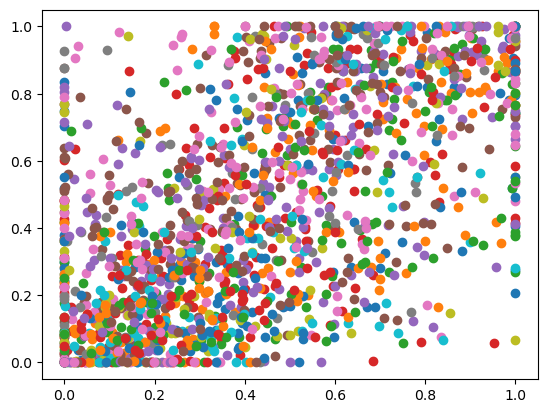

In [193]:
# for index,item in enumerate(np.array(neuron_rel_forward_replay_positions)[np.array(expert_bool) == 1]):
#     plt.plot(item,np.array(neuron_rel_awake_positions_forwards)[np.array(expert_bool) == 1][index],'o')
    
for index,item in enumerate(np.array(neuron_rel_forward_replay_positions)[np.array(hlesion_bool) == 1]):
    plt.plot(item,np.array(neuron_rel_awake_positions_forwards)[np.array(hlesion_bool) == 1][index],'o')
    
# for index,item in enumerate(np.array(neuron_rel_forward_replay_positions)[np.array(learning_bool) == 1]):
#     plt.plot(item,np.array(neuron_rel_awake_positions_forwards)[np.array(learning_bool) == 1][index],'o')

# Neuron awake - sleep relationship

In [29]:
def return_binned_neuron_awake_sleep_rel(awake_dat,sleep_dat):
    awake_sleep_relationship = {}
    for key in awake_dat:
        for index, awake_mouse_data in enumerate(awake_dat[key]):

#             sleep_neurs = np.array(sleep_dat[key][index])
#             mask1 = np.array(awake_mouse_data)>0
#             mask2 = np.array(sleep_neurs)>0
# #             mask = mask1*mask2
#             mask = mask1
#             awake = np.array(awake_mouse_data)[mask]
#             sleep = sleep_neurs[mask]

            awake = awake_mouse_data
            sleep = np.array(sleep_dat[key][index])

            min_neurons_filter = 0
            bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]    

            if mouse in expert_mice:
                for bin_ in bins:
                    mask = np.round(awake,1) == bin_
                    if len(sleep[mask]) > min_neurons_filter:
                        if bin_ in awake_sleep_relationship:
                            awake_sleep_relationship[bin_] += [np.mean(sleep[mask])]
                        else:
                            awake_sleep_relationship[bin_] = [np.mean(sleep[mask])]

    return awake_sleep_relationship

In [34]:
len(e_awake_rich_neuron_involvement_data_task_only[1])

39

{1: [[0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.017241379310344827,
   0.034482758620689655,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.017241379310344827,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.017241379310344827,
   0.0,
   0.0,
   0.1206896551724138,
   0.0,
   0.0,
   0.0,
   0.034482758620689655,
   0.3103448275862069,
   0.0,
   0.0,
   0.08620689655172414,
   0.13793103448275862,
   0.10344827586206896,
   0.10344827586206896,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.017241379310344827,
   0.017241379310344827,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.017241379310344827,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.05172413793103448,
   0.0,
   0.0,
   0.0,
   0.0,
   0.13793103448275862,
   0.05172413793103448,
   0.0344827586

In [40]:


# File path to save the dictionary
file_path = r'C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4\sleep_neuron-involvement_by-seq_by-recording.json'

# Save the dictionary to a file
with open(file_path, 'w') as file:
    json.dump(e_sleep_rich_neuron_involvement_data_task_only, file)

Fitted parameters: a = 0.019298565713083783, b = 3.654956962764572
R-squared: 0.9889187059570987
p-values: [0.00027847822507531816, 7.999531015379091e-08]


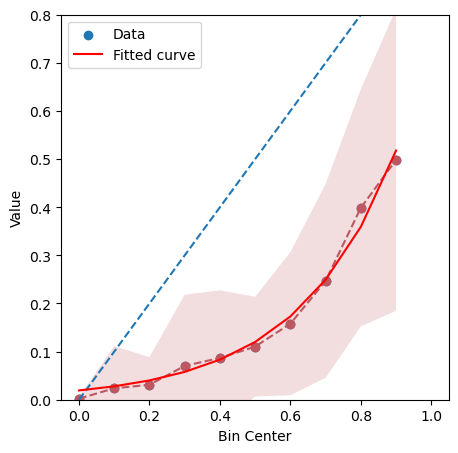

In [30]:
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(e_awake_rich_neuron_involvement_data_task_only,e_sleep_rich_neuron_involvement_data_task_only)

fig, ax = plt.subplots(1, 1,figsize=(5, 5))

keys = []
e_means = []
sem = []
for key in awake_sleep_relationship:
    if len(awake_sleep_relationship[key]) > 0:
        keys += [key]
#         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')
        e_means += [np.mean(awake_sleep_relationship[key])]
        sem += [scipy.stats.tstd(awake_sleep_relationship[key])]
ax.plot(sorted(keys),np.array(e_means)[np.argsort(keys)],'o--', c = red)

upper = np.array(e_means)[np.argsort(keys)] + sem
lower = np.array(e_means)[np.argsort(keys)] - sem
ax.fill_between(sorted(keys),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=red,
    linewidth=1, linestyle='dashdot', antialiased=True)

x = np.linspace(0, 1, 10)  # Example x values
y = x  # Since x equals y, y values are the same as x values
plt.plot(x,y,'--')


ax.set_ylim(0,0.8)


ax.set_ylabel('replay proportion involvement')
ax.set_xlabel('awake proportion involvement')

#################################################

from scipy.optimize import curve_fit
from scipy.stats import t

# Extract the bins and corresponding values
bins = list(awake_sleep_relationship.keys())
bin_centers = np.array(bins)
values = np.array([np.mean(awake_sleep_relationship[bin]) for bin in bins])

# Define the exponential function
def exponential_model(x, a, b):
    return a * np.exp(b * x)

# Fit the model to the data
popt, pcov = curve_fit(exponential_model, bin_centers, values)

# Extract the fitting parameters
a, b = popt

# Calculate the fitted values
fitted_values = exponential_model(bin_centers, *popt)

# Calculate R-squared
residuals = values - fitted_values
ss_res = np.sum(residuals**2)
ss_tot = np.sum((values - np.mean(values))**2)
r_squared = 1 - (ss_res / ss_tot)

# Degrees of freedom
dof = max(0, len(bin_centers) - len(popt))

# Calculate standard errors of the parameters
perr = np.sqrt(np.diag(pcov))

# Calculate t-values for the parameters
t_values = popt / perr

# Calculate p-values for the parameters
p_values = [2 * (1 - t.cdf(np.abs(t_val), dof)) for t_val in t_values]

print(f'Fitted parameters: a = {a}, b = {b}')
print(f'R-squared: {r_squared}')
print(f'p-values: {p_values}')


# Plot the original data and the fitted curve
plt.scatter(bin_centers, values, label='Data')
plt.plot(bin_centers, fitted_values, label='Fitted curve', color='red')
plt.xlabel('Bin Center')
plt.ylabel('Value')
plt.legend()






SaveFig('neuron_involvement_expert.pdf','D:\\')

In [280]:
np.sqrt(r_squared)

0.9944439179547023

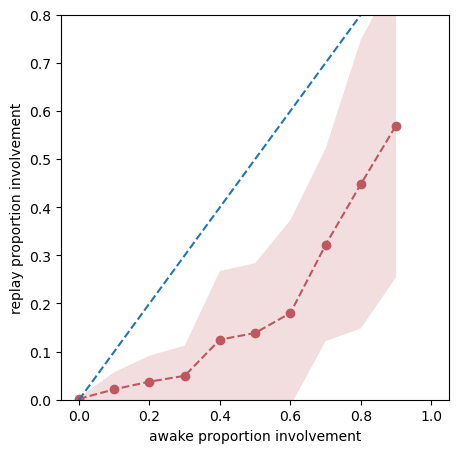

In [13]:
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(l_awake_rich_neuron_involvement_data_task_only,l_sleep_rich_neuron_involvement_data_task_only)

fig, ax = plt.subplots(1, 1,figsize=(5, 5))

keys = []
l_means = []
sem = []
for key in awake_sleep_relationship:
    if len(awake_sleep_relationship[key]) > 0:
        keys += [key]
#         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')
        l_means += [np.mean(awake_sleep_relationship[key])]
        sem += [scipy.stats.tstd(awake_sleep_relationship[key])]
ax.plot(sorted(keys),np.array(l_means)[np.argsort(keys)],'o--', c = red)

upper = np.array(l_means)[np.argsort(keys)] + sem
lower = np.array(l_means)[np.argsort(keys)] - sem
ax.fill_between(sorted(keys),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=red,
    linewidth=1, linestyle='dashdot', antialiased=True)

x = np.linspace(0, 1, 10)  # Example x values
y = x  # Since x equals y, y values are the same as x values
plt.plot(x,y,'--')

ax.set_ylim(0,0.8)



ax.set_ylabel('replay proportion involvement')
ax.set_xlabel('awake proportion involvement')

SaveFig('neuron_involvement_learning.pdf','D:\\')

In [8]:
awake_sleep_relationship = return_binned_neuron_awake_sleep_rel(hl_awake_rich_neuron_involvement_data_task_only,hl_sleep_rich_neuron_involvement_data_task_only)

fig, ax = plt.subplots(1, 1,figsize=(5, 5))

keys = []
hl_means = []
sem = []
for key in awake_sleep_relationship:
    if len(awake_sleep_relationship[key]) > 0:
        keys += [key]
#         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')
        hl_means += [np.mean(awake_sleep_relationship[key])]
        sem += [scipy.stats.tstd(awake_sleep_relationship[key])]
ax.plot(sorted(keys),np.array(hl_means)[np.argsort(keys)],'o--', c = red)

upper = np.array(hl_means)[np.argsort(keys)] + sem
lower = np.array(hl_means)[np.argsort(keys)] - sem
ax.fill_between(sorted(keys),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=red,
    linewidth=1, linestyle='dashdot', antialiased=True)

x = np.linspace(0, 1, 10)  # Example x values
y = x  # Since x equals y, y values are the same as x values
plt.plot(x,y,'--')


ax.set_ylim(0,0.8)


ax.set_ylabel('replay proportion involvement')
ax.set_xlabel('awake proportion involvement')

SaveFig('neuron_involvement_h_lesion.pdf',out_path)


NameError: name 'return_binned_neuron_awake_sleep_rel' is not defined

In [156]:
x = e_means
y = sorted(e_awake_sleep_relationship)

x2 = l_means
y2 = sorted(l_awake_sleep_relationship)

import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

A = pd.DataFrame({'x': x,
                  'y': y})
B = pd.DataFrame({'x': x2,
                  'y': y2})
# Combine the data into one DataFrame
data = pd.concat([A, B], axis=0)

# Create a grouping variable
groups = np.array(['A'] * len(x) + ['B'] * len(x2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3186 2.0000 17.0000 18.1782 0.0001
         Pillai's trace 0.6814 2.0000 17.0000 18.1782 0.0001
 Hotelling-Lawley trace 2.1386 2.0000 17.0000 18.1782 0.0001
    Roy's greatest root 2.1386 2.0000 17.0000 18.1782 0.0001
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.9596 2.0000 17.0000  0.3580 0.7042
         Pillai's trace 0.0404 2.0000 17.0000  0.3580 0.7042
 Hotelling-Lawley trace 0.0421 2.0000 17.0

# neuron involvement  -OLD

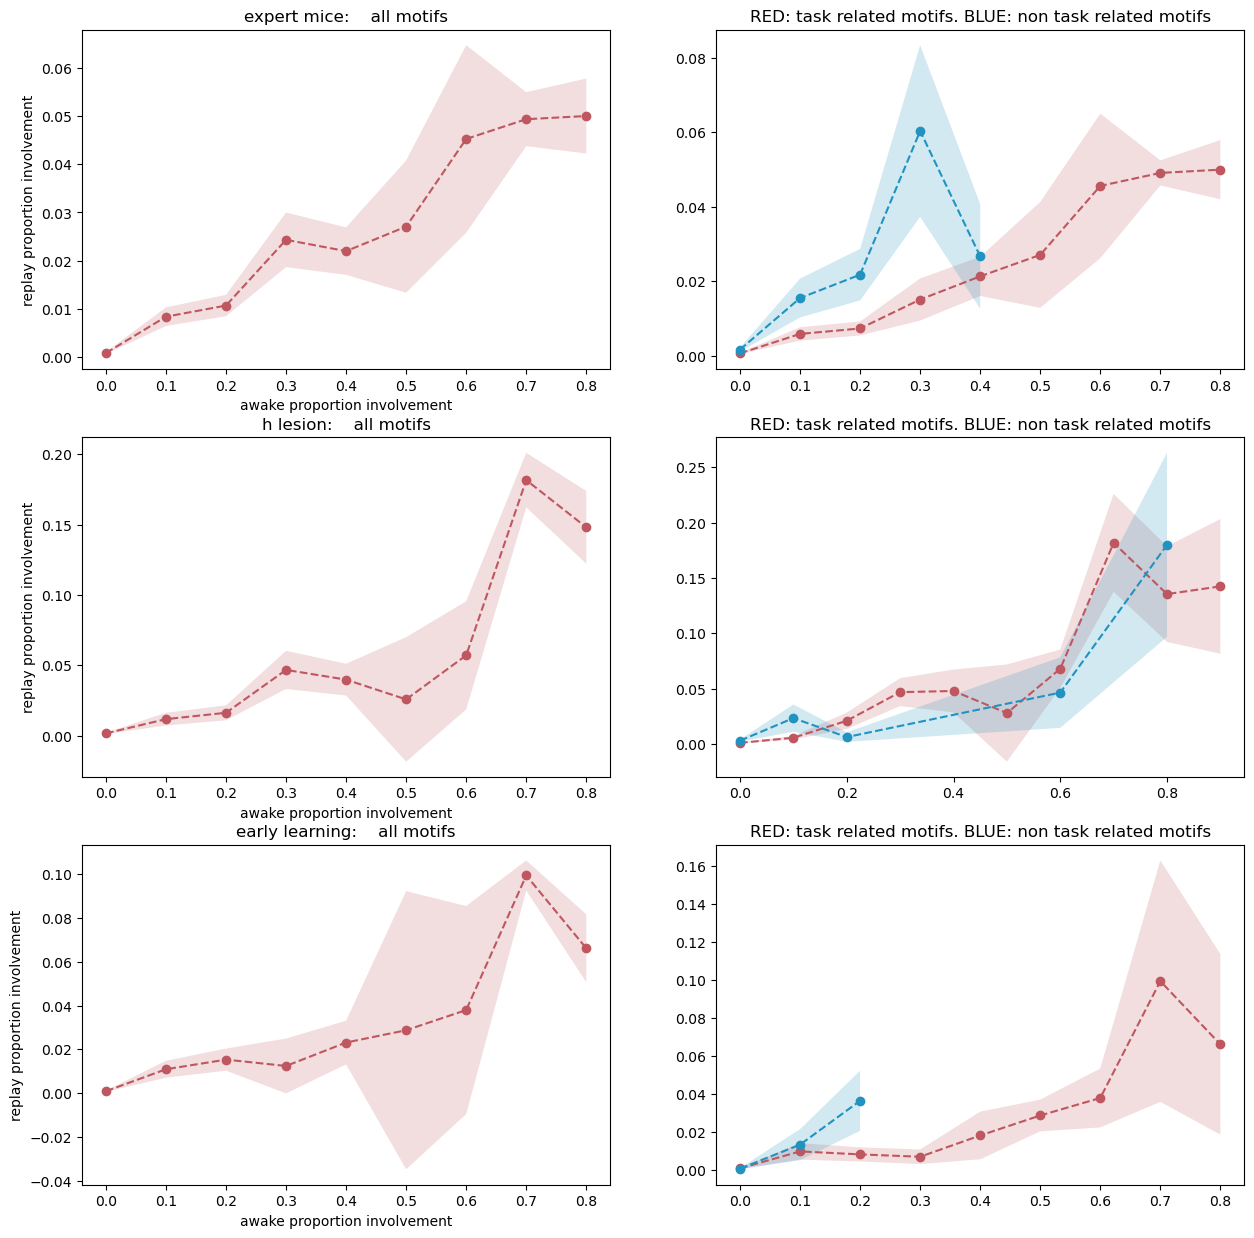

In [49]:
# fig, [(ax,ax2),(ax3,ax4),(ax5,ax6)]= plt.subplots(3, 2,figsize=(15, 15))


# def plot_neuron_involvement(ax,ax2,dat1,dat2,dat3,str_var):

#     keys = []
#     means = []
#     sem = []
#     for key in e_awake_sleep_relationship:
#         if len(e_awake_sleep_relationship[key]) > 5:
#             keys += [key]
#     #         ax.plot([key]* len(e_awake_sleep_relationship[key]),e_awake_sleep_relationship[key],'o', color = 'red')
#             means += [np.mean(dat1[key])]
#             sem += [scipy.stats.sem(dat1[key])]
#     ax.plot(sorted(keys),np.array(means)[np.argsort(keys)],'o--', c = red)

#     upper = np.array(means)[np.argsort(keys)] + sem
#     lower = np.array(means)[np.argsort(keys)] - sem
#     ax.fill_between(sorted(keys),(lower),(upper),
#         alpha=0.2, edgecolor='None', facecolor=red,
#         linewidth=1, linestyle='dashdot', antialiased=True)

#     ax.set_title(str_var + ':    all motifs')

#     keys = []
#     means = []
#     sem = []
#     for key in dat2:
#         if len(dat2[key]) > 5:
#             keys += [key]
#     #         ax.plot([key]* len(e_task_awake_sleep_relationship[key]),e_task_awake_sleep_relationship[key],'o', color = 'red')
#             means += [np.mean(dat2[key])]
#             sem += [scipy.stats.sem(dat2[key])]
#     ax2.plot(sorted(keys),np.array(means)[np.argsort(keys)],'o--', c = red)

#     upper = np.array(means)[np.argsort(keys)] + sem
#     lower = np.array(means)[np.argsort(keys)] - sem
#     ax2.fill_between(sorted(keys),(lower),(upper),
#         alpha=0.2, edgecolor='None', facecolor=red,
#         linewidth=1, linestyle='dashdot', antialiased=True)

#     ax2.set_title('RED: task related motifs. BLUE: non task related motifs')

#     keys = []
#     means = []
#     sem = []
#     for key in dat3:
#         if len(dat3[key]) > 5:
#             keys += [key]
#     #         ax3.plot([key]* len(e_non_task_awake_sleep_relationship[key]),e_non_task_awake_sleep_relationship[key],'o', color = 'red')
#             means += [np.mean(dat3[key])]
#             sem += [scipy.stats.sem(dat3[key])]
#     ax2.plot(sorted(keys),np.array(means)[np.argsort(keys)],'o--', c = blue)

#     upper = np.array(means)[np.argsort(keys)] + sem
#     lower = np.array(means)[np.argsort(keys)] - sem
#     ax2.fill_between(sorted(keys),(lower),(upper),
#         alpha=0.2, edgecolor='None', facecolor=blue,
#         linewidth=1, linestyle='dashdot', antialiased=True)
    
#     ax.set_ylabel('replay proportion involvement')
#     ax.set_xlabel('awake proportion involvement')
    

    
# plot_neuron_involvement(ax,ax2,e_awake_sleep_relationship,e_task_awake_sleep_relationship,e_non_task_awake_sleep_relationship,'expert mice')
# plot_neuron_involvement(ax3,ax4,hl_awake_sleep_relationship,hl_task_awake_sleep_relationship,hl_non_task_awake_sleep_relationship,'h lesion')
# plot_neuron_involvement(ax5,ax6,l_awake_sleep_relationship,l_task_awake_sleep_relationship,l_non_task_awake_sleep_relationship,'early learning')

# SaveFig('neuron_involvement.pdf',out_path)

In [43]:
# start_end_df.to_csv(r"C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4\start_end_df.csv")

#  start and end points 

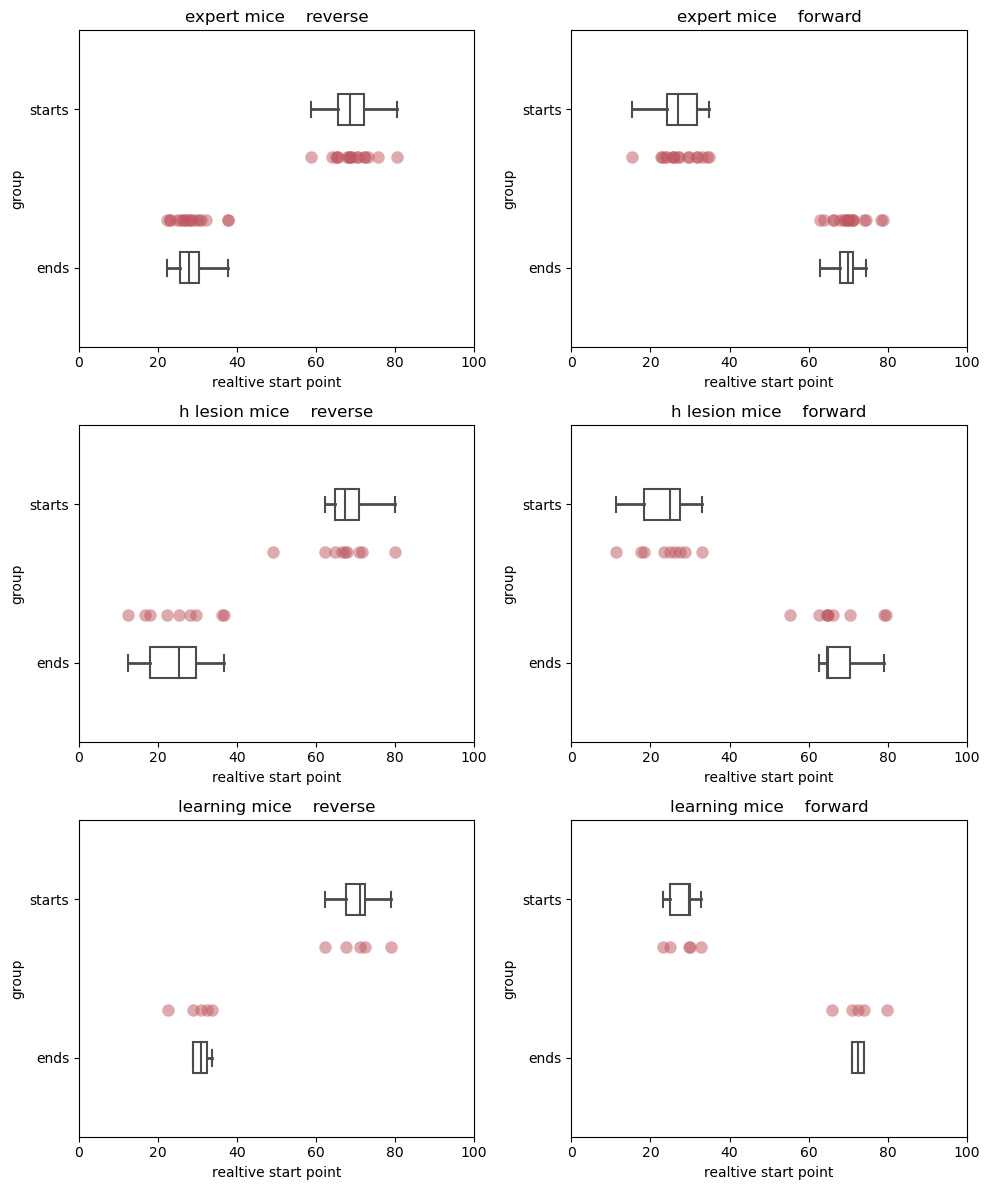

In [290]:
e_all_chunk_forward_start_mean = []
e_all_chunk_forward_end_mean = []
e_all_chunk_reverse_start_mean = []
e_all_chunk_reverse_end_mean = []
hl_all_chunk_forward_start_mean = []
hl_all_chunk_forward_end_mean = []
hl_all_chunk_reverse_start_mean = []
hl_all_chunk_reverse_end_mean = []
l_all_chunk_forward_start_mean = []
l_all_chunk_forward_end_mean = []
l_all_chunk_reverse_start_mean = []
l_all_chunk_reverse_end_mean = []
# s_o_d = []
for mouse,group in start_end_df.groupby('mouse'):
    chunk_forward_start_mean = []
    chunk_forward_end_mean = []
    chunk_reverse_start_mean = []
    chunk_reverse_end_mean = []
    for diff, chunk in group.groupby('sleep_onset_diff'):
        forward_chunk = chunk[chunk.label == 'forward']
        chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
        chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

        reverse_chunk = chunk[chunk.label == 'reverse']
        chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
        chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

#         s_o_d += [sleep_onset_diff]
        
    if mouse in expert_mice:
        e_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        e_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        e_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        e_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
    elif mouse in hlesion_mice:
        hl_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        hl_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        hl_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        hl_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
    elif mouse in learning_mice:
        l_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        l_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        l_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        l_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]


def plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,var_str):
        
    ## plot forward start and ends

    ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) 
    data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax)
        ax.set_xlabel('realtive start point')
        ax.set_title(var_str + '    reverse')

    ax.set_xlim(0,100)

    ###########

    ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 9)

    ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 9)


    groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) 
    data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean

    if len(data) > 0:
        forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
        ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                    showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                    showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                       saturation = 1, orient = 'h',ax = ax2)


        ax2.set_xlabel('realtive start point')
        ax2.set_title(var_str + '    forward')


    ax2.set_xlim(0,100)
    
    
fig,[(ax,ax2),(ax3,ax4),(ax5,ax6)] = plt.subplots(3, 2,figsize=(10, 12))
    
    
plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,'expert mice')
plot_start_end_times(hl_all_chunk_reverse_start_mean,hl_all_chunk_forward_start_mean,hl_all_chunk_reverse_end_mean,hl_all_chunk_forward_end_mean,ax3,ax4,'h lesion mice')
plot_start_end_times(l_all_chunk_reverse_start_mean,l_all_chunk_forward_start_mean,l_all_chunk_reverse_end_mean,l_all_chunk_forward_end_mean,ax5,ax6,'learning mice')

plt.tight_layout()

SaveFig('start_end_points.pdf','D:\\')

In [295]:
group1 = e_all_chunk_forward_start_mean
group2 = e_all_chunk_forward_end_mean
group3 = e_all_chunk_reverse_start_mean
group4 = e_all_chunk_reverse_end_mean
group5 = l_all_chunk_forward_start_mean
group6 = l_all_chunk_forward_end_mean
group7 = l_all_chunk_reverse_start_mean
group8 = l_all_chunk_reverse_end_mean


stats.shapiro(l_all_chunk_reverse_end_mean)

## all are normal so use MANOVA



ShapiroResult(statistic=0.8949854373931885, pvalue=0.38279402256011963)

In [296]:
from statsmodels.multivariate.manova import MANOVA
data = {
    'group': ['control']*len(group1)+['lesion']*len(group5),
    'forward_start': group1+group5,
    'forward_end': group2+group6,
    'reverse_start': group3+group7,
    'reverse_end': group4+group8,
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value   Num DF  Den DF F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda   0.0044 4.0000 17.0000 963.9953 0.0000
         Pillai's trace   0.9956 4.0000 17.0000 963.9953 0.0000
 Hotelling-Lawley trace 226.8224 4.0000 17.0000 963.9953 0.0000
    Roy's greatest root 226.8224 4.0000 17.0000 963.9953 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
            group          Value  Num DF  Den DF F Value Pr > F
---------------------------------------------------------------
             Wilks' lambda 0.8892 4.0000 17.0000  0.5296 0.7157
            Pillai's trace 0.1108 4.0000 17.0000  0.5296 0.

In [ ]:
from scipy import stats



In [97]:
group1 = e_all_chunk_forward_start_mean
group2 = e_all_chunk_forward_end_mean
group3 = e_all_chunk_reverse_start_mean
group4 = e_all_chunk_reverse_end_mean
group5 = l_all_chunk_forward_start_mean
group6 = l_all_chunk_forward_end_mean
group7 = l_all_chunk_reverse_start_mean
group8 = l_all_chunk_reverse_end_mean

stats.shapiro(group8)
# all are normal 

s,p__ = scipy.stats.kruskal(group1,group2,group3,group4,group5,group6,group7,group8)
print(p__)
tukey_result = scipy.stats.tukey_hsd(group1,group2,group3,group4,group5,group6,group7,group8)

sp.posthoc_dunn([group1,group2,group3,group4,group5,group6,group7,group8])


9.112403660007581e-12


,1,2,3,4,5,6,7,8
1,1.000000e+00,2.037973e-07,0.000001,9.197929e-01,0.876277,0.000055,0.000399,0.610321
2,2.037973e-07,1.000000e+00,0.757476,3.484733e-07,0.000816,0.595811,0.969674,0.002759
3,1.023615e-06,7.574762e-01,1.000000,1.698427e-06,0.001694,0.460135,0.805521,0.005349
4,9.197929e-01,3.484733e-07,0.000002,1.000000e+00,0.930034,0.000073,0.000514,0.658687
5,8.762770e-01,8.158980e-04,0.001694,9.300339e-01,1.000000,0.001813,0.006466,0.775877
6,5.495957e-05,5.958113e-01,0.460135,7.321764e-05,0.001813,1.000000,0.692032,0.004588
7,3.985348e-04,9.696738e-01,0.805521,5.143611e-04,0.006466,0.692032,1.000000,0.014749
8,6.103215e-01,2.758697e-03,0.005349,6.586872e-01,0.775877,0.004588,0.014749,1.000000


# warp 

In [26]:
def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        rels += [list(np.array(item)/sum(item))]
    return rels

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

e_f_warp_factors = []
e_r_warp_factors = []
hl_f_warp_factors = []
hl_r_warp_factors = []
l_f_warp_factors = []
l_r_warp_factors = []

e_forward = []
e_reverse = []
hl_forward = []
hl_reverse = []
l_forward = []
l_reverse = []

ef_data = []
er_data = []
hlf_data = []
hlr_data = []
lf_data = []
lr_data = []

for mouse, group in regression_df.groupby('mouse'):
    if mouse in expert_mice:

        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        ef_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_f_warp_factors +=[list(example_totals.values())]
        e_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        er_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_r_warp_factors +=[list(example_totals.values())]
        e_reverse += [sum(example_totals.values())]
    elif mouse in hlesion_mice:
        print(mouse)
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        hlf_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_f_warp_factors +=[list(example_totals.values())]
        hl_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        hlr_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_r_warp_factors +=[list(example_totals.values())]
        hl_reverse += [sum(example_totals.values())]
    elif mouse in learning_mice:
        print(mouse)
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        lf_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        l_f_warp_factors +=[list(example_totals.values())]
        l_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        lr_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        l_r_warp_factors +=[list(example_totals.values())]
        l_reverse += [sum(example_totals.values())]
        
e_f_warp_factors = relative_warp_values(e_f_warp_factors)
e_r_warp_factors = relative_warp_values(e_r_warp_factors)
hl_f_warp_factors = relative_warp_values(hl_f_warp_factors)
hl_r_warp_factors = relative_warp_values(hl_r_warp_factors)
l_f_warp_factors = relative_warp_values(l_f_warp_factors)
l_r_warp_factors = relative_warp_values(l_r_warp_factors)


255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6
268_1_2
269_1_1
269_1_2
269_1_3
270_1_3


In [24]:
# regression_df.to_csv(r"C:\Users\Emmett\Documents\REPLAY_PAPER\data\f4\warps_df.csv")

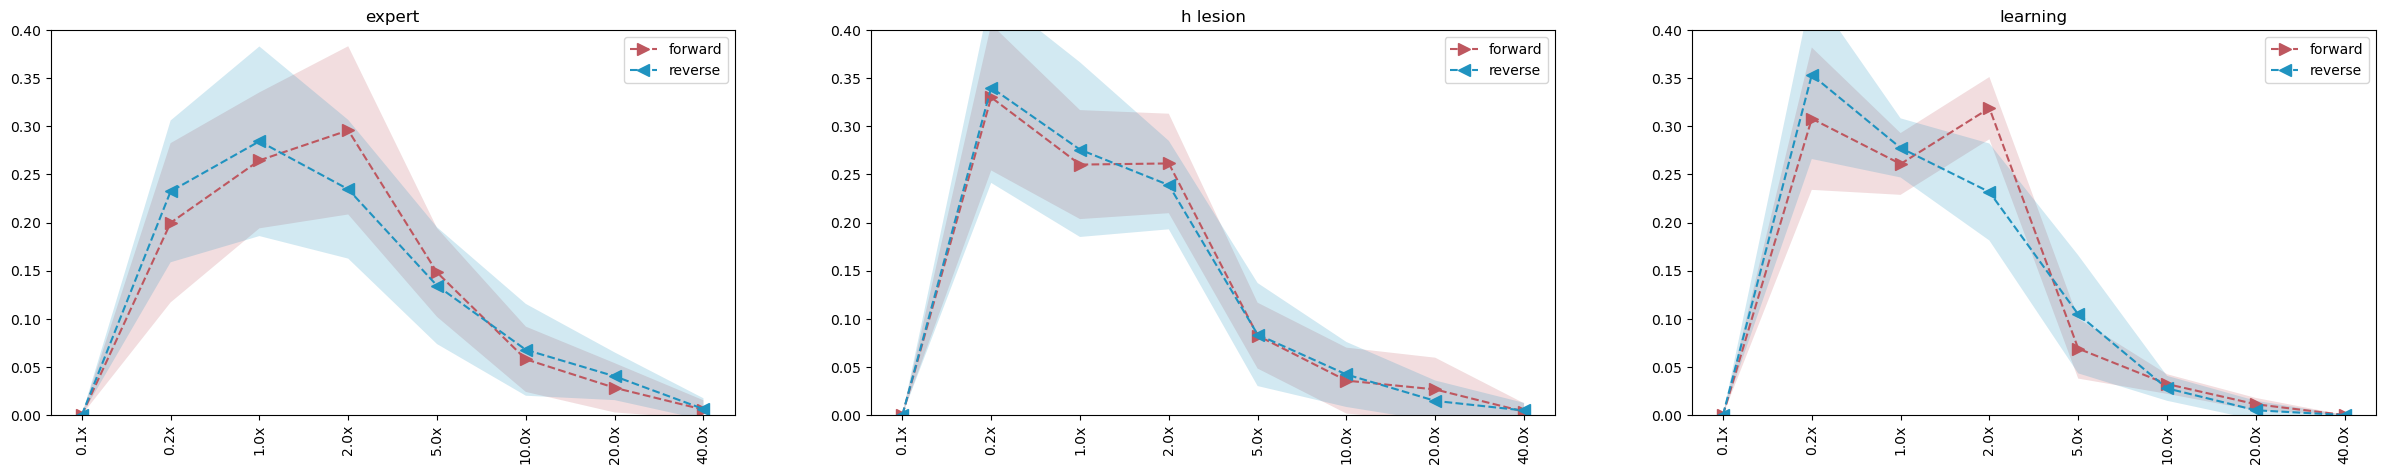

In [27]:
### i thnk this is currnetly just the sequential ones... i guess this makes sense as only these have a warp? 

    
def plot_warps(e_f_warp_factors,e_r_warp_factors,ax,var_str):

    bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

    means = []
    sems = []
    data_out_f = []
    for item in conactinate_nth_items(e_f_warp_factors):
        means += [np.mean(item)]
        sems += [np.std(item)]
        data_out_f += [item]
    ax.plot(means,'-->', color = red, markersize = 8, label = 'forward')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=red,
        linewidth=1, linestyle='dashdot', antialiased=True)

    means = []
    sems = []
    data_out_r = []
    for item in conactinate_nth_items(e_r_warp_factors):
        means += [np.mean(item)]
        sems += [np.std(item)]
        data_out_r += [item]
    ax.plot(means,'--<', color = blue, markersize = 8,label = 'reverse')
    upper = np.array(means)+ sems
    lower = np.array(means)- sems
    ax.fill_between((range(len(bin_labels))),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=blue,
        linewidth=1, linestyle='dashdot', antialiased=True)
    ax.set_title(var_str)
    
    # Set the vertical labels
    ax.set_xticks(range(len(bin_labels)))
    ax.set_xticklabels(bin_labels, rotation=90)
    
    ax.set_ylim(0,0.40)

    ax.legend()
    
    return(data_out_f,data_out_r)
    
    
fig,[ax,ax1,ax2] = plt.subplots(1, 3,figsize=(30, 5))
e_data_f,e_data_r = plot_warps(e_f_warp_factors,e_r_warp_factors,ax,'expert')
hl_data_f,hl_data_r = plot_warps(hl_f_warp_factors,hl_r_warp_factors,ax1,'h lesion')
l_data_f,l_data_r = plot_warps(l_f_warp_factors,l_r_warp_factors,ax2,'learning')
    


# means = []




SaveFig('warp_factors.pdf',out_path)


In [187]:
from scipy import stats
stats.shapiro([item for sublist in hl_f_warp_factors for item in sublist])



ShapiroResult(statistic=0.8376883268356323, pvalue=2.0625249419481406e-07)

In [86]:
import scikit_posthocs as sp

def stars(p):  
    stars = []
    if p < 0.05 and p > 0.01:
        stars+=['*']
    elif p < 0.01 and p > 0.001:
        stars+=['**']
    elif p < 0.001:
        stars+=['***']
    elif p > 0.05:
        stars+=['ns']
    return(stars)


data1 = e_data_f
data2 = e_data_r
data3 = l_data_f
data4 = l_data_r

s,p__ = scipy.stats.kruskal(*(data1 + data2 + data3 + data4))
print(p__)


groups = []
labels = ['ef_','er_','hlf_','hlr_']
for i,data in enumerate([data1,data2,data3,data4]):
    print(len(data))
    for index,item in enumerate(data):
        groups+=[labels[i]+str(index)]*len(item)
data_df = pd.DataFrame({'values': [item for sublist in (data1 + data2 + data3+data4) for item in sublist], 'groups': groups})
dunn_results = sp.posthoc_dunn(data_df, val_col='values', group_col='groups')


all_f_ps = []
all_r_ps = []
_stars = []
_p = []
for i in range(len(data1)):
    f_p = dunn_results['ef_' + str(i)]['hlf_'+str(i)]
    r_p = dunn_results['er_' + str(i)]['hlr_'+str(i)]
    
    all_f_ps += ['p = ' + str(round(f_p, 5))]
    all_r_ps += ['p = ' + str(round(r_p, 5))]
     
print(all_r_ps)
print(all_f_ps)

3.6224345892817133e-47
8
8
8
8
['p = 1.0', 'p = 0.27136', 'p = 0.81811', 'p = 0.99653', 'p = 0.76987', 'p = 0.59003', 'p = 0.17743', 'p = 0.6888']
['p = 1.0', 'p = 0.21592', 'p = 0.93844', 'p = 0.7244', 'p = 0.3231', 'p = 0.68441', 'p = 0.82961', 'p = 0.59573']


In [ ]:
## fro each mouse-condition, stack each warp value 

# for the first figure this is forward and reverse

# for the second try all 4 at once. PERMANOVA for sure



In [298]:
# PERMANOVA forward vs reverse diff

from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

grouping = ['control_forwards']*len(np.vstack(hl_f_warp_factors)) + ['control_reverse']*len(np.vstack(hl_r_warp_factors))

stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test

pairwise_distances = pdist(np.asarray(hl_f_warp_factors+hl_r_warp_factors), metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             0.208189
p-value                    0.911509
number of permutations        10000
Name: PERMANOVA results, dtype: object


In [283]:
# PERMANOVA forward vs reverse diff

from skbio.stats.distance import permanova, DistanceMatrix
from skbio import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import DistanceMatrix
from skbio.stats.distance import permanova

# grouping = ['control_forwards']*len(np.vstack(e_f_warp_factors)) + ['control_reverse']*len(np.vstack(e_r_warp_factors)) + ['lesion_forwards']*len(np.vstack(hl_f_warp_factors)) + ['lesion_reverse']*len(np.vstack(hl_r_warp_factors))
grouping = ['control']*len(np.vstack(e_f_warp_factors)) + ['control']*len(np.vstack(e_r_warp_factors)) + ['lesion']*len(np.vstack(l_f_warp_factors)) + ['lesion']*len(np.vstack(l_r_warp_factors))
# data is stacked so that each row is a sample (animal) and each colum is a variable/test



# pairwise_distances = pdist(np.asarray([sublist[1:-1] for sublist in e_f_warp_factors]+[sublist[1:-1] for sublist in e_r_warp_factors]+[sublist[1:-1] for sublist in hl_f_warp_factors]+[sublist[1:-1] for sublist in hl_r_warp_factors]), metric='euclidean')

pairwise_distances = pdist(np.asarray(e_f_warp_factors+e_r_warp_factors+l_f_warp_factors+l_r_warp_factors), metric='euclidean')

distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      44
number of groups                  2
test statistic             5.553871
p-value                      0.0018
number of permutations        10000
Name: PERMANOVA results, dtype: object


In [284]:
import numpy as np
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests

def pairwise_permanova(distance_matrix, group_labels, method='bonferroni'):
    unique_groups = np.unique(group_labels)
    pairwise_combinations = list(combinations(unique_groups, 2))
    results = []
    p_values = []

    for group1, group2 in pairwise_combinations:
        mask = np.isin(group_labels, [group1, group2])
        pairwise_distance_matrix = distance_matrix[mask][:, mask]
        pairwise_group_labels = group_labels[mask]
        
        # Ensure the array is contiguous
        pairwise_distance_matrix = np.ascontiguousarray(pairwise_distance_matrix)
        
        # Create a DistanceMatrix object
        ids = np.arange(len(pairwise_group_labels))
        pairwise_distance_matrix = DistanceMatrix(pairwise_distance_matrix, ids)
        
        result = permanova(pairwise_distance_matrix, pairwise_group_labels,permutations=10000)
        results.append((group1, group2, result))
        p_values.append(result['p-value'])
    
    # Apply Bonferroni correction
    corrected_p_values = multipletests(p_values, method=method)[1]
    
    # Update results with corrected p-values
    for i in range(len(results)):
        results[i][2]['p-value'] = corrected_p_values[i]

    return results

# Example usage:

# Assuming `data` is your dataset and `group` is the corresponding group labels
# Compute distance matrix (e.g., Bray-Curtis distance)
# from skbio.diversity import beta_diversity
# distance_matrix = beta_diversity('braycurtis', data, ids=group)


# Perform pairwise PERMANOVA with Bonferroni correction
results = pairwise_permanova(dm, np.array(grouping))

for group1, group2, result in results:
    if result['p-value'] < 0.05:
        print('---------------------------------------------')
        print(f"Comparison: {group1} vs {group2}")
        print(f"P-value (corrected): {result['p-value']}")
        print(result)

---------------------------------------------
Comparison: control vs lesion
P-value (corrected): 0.0027997200279972004
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      44
number of groups                  2
test statistic             5.553871
p-value                      0.0028
number of permutations        10000
Name: PERMANOVA results, dtype: object


In [288]:
import numpy as np
from itertools import combinations
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from statsmodels.stats.multitest import multipletests
from scipy.spatial.distance import pdist, squareform

def pairwise_permanova_by_feature(data, group_labels, method='bonferroni'):
    unique_groups = np.unique(group_labels)
    pairwise_combinations = list(combinations(unique_groups, 2))
    feature_results = []
    feature_p_values = []

    num_features = data.shape[1]

    for feature_index in range(num_features):
        feature_data = data[:, feature_index]
        
        for group1, group2 in pairwise_combinations:
            mask = np.isin(group_labels, [group1, group2])
            pairwise_feature_data = feature_data[mask]
            pairwise_group_labels = group_labels[mask]
            
            # Compute the distance matrix for the feature
            pairwise_distance_matrix = squareform(pdist(pairwise_feature_data[:, np.newaxis], metric='euclidean'))
            
            # Ensure the array is contiguous
            pairwise_distance_matrix = np.ascontiguousarray(pairwise_distance_matrix)
            
            # Create a DistanceMatrix object
            ids = np.arange(len(pairwise_group_labels))
            pairwise_distance_matrix = DistanceMatrix(pairwise_distance_matrix, ids)
            
            result = permanova(pairwise_distance_matrix, pairwise_group_labels,permutations=10000)
            feature_results.append((feature_index, group1, group2, result))
            feature_p_values.append(result['p-value'])
    
    # Apply Bonferroni correction
    corrected_p_values = multipletests(feature_p_values, method=method)[1]

    # Update results with corrected p-values
    for i in range(len(feature_results)):
        feature_results[i][3]['p-value'] = corrected_p_values[i]

    return feature_results

# Example usage:


# Perform pairwise PERMANOVA on each feature with Bonferroni correction
# feature_results = pairwise_permanova_by_feature(np.asarray([sublist[1:-1] for sublist in e_f_warp_factors]+[sublist[1:-1] for sublist in e_r_warp_factors]+[sublist[1:-1] for sublist in hl_f_warp_factors]+[sublist[1:-1] for sublist in hl_r_warp_factors]), np.array(grouping))
feature_results = pairwise_permanova_by_feature(np.asarray(e_f_warp_factors+e_r_warp_factors+l_f_warp_factors+l_r_warp_factors), np.array(grouping))


print("Feature-wise Pairwise Results:")
for feature_index, group1, group2, result in feature_results:
    if result['p-value'] < 0.05:
        print(f"Feature {feature_index}: Comparison: {group1} vs {group2}")
        print(f"P-value (corrected): {result['p-value']}")
        print(result)
        print('-------------------------------')
        
        if result['p-value'] < 0.001:
            print('***')
        elif result['p-value'] < 0.01:
            print('**')
        else:
            print('*')
        print('______')
        


C:\Users\Emmett\anaconda3\lib\site-packages\skbio\stats\distance\_permanova.py:129: RuntimeWarning: invalid value encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))


Feature-wise Pairwise Results:
Feature 0: Comparison: control vs lesion
P-value (corrected): 0.0007999200079992001
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      44
number of groups                  2
test statistic                  NaN
p-value                      0.0008
number of permutations        10000
Name: PERMANOVA results, dtype: object
-------------------------------
***
______
Feature 1: Comparison: control vs lesion
P-value (corrected): 0.005599440055994401
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      44
number of groups                  2
test statistic             14.78459
p-value                    0.005599
number of permutations        10000
Name: PERMANOVA results, dtype: object
-------------------------------
**
______
Feature 6: Comparison: control vs lesion
P-value (corrected): 0.0327967203279672
method name               PERMANOVA
test statistic nam

In [287]:
feature_index

7

In [71]:
import skbio
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Assuming you have a distance matrix 'distance_matrix' and a grouping vector 'group'

# Pairwise PERMANOVA with Bonferroni correction
def pairwise_permanova(distance_matrix, group):
    groups = np.unique(group)
    pairwise_combinations = list(combinations(groups, 2))
    p_values = []
    results = []
    
    for (grp1, grp2) in pairwise_combinations:
        mask = (group == grp1) | (group == grp2)
        pairwise_distance_matrix = distance_matrix[mask][:, mask]
        pairwise_group = group[mask]
        result = skbio.stats.distance.permanova(pairwise_distance_matrix, grouping=pairwise_group)
        p_values.append(result['p-value'])
        results.append((grp1, grp2, result))
    
    # Apply Bonferroni correction
    corrected_p_values = multipletests(p_values, method='bonferroni')[1]
    
    for i, (grp1, grp2, result) in enumerate(results):
        result['p-value'] = corrected_p_values[i]
        print(f"Comparison: {grp1} vs {grp2}")
        print(result)

pairwise_results = pairwise_permanova(dm, grouping)

TypeError: Input must be a DistanceMatrix.

In [93]:
groups = np.unique(grouping)
pairwise_combinations = list(combinations(groups, 2))
p_values = []
results = []

for (group1, group2) in pairwise_combinations:
    mask = np.isin(grouping, [group1, group2])
    pairwise_distance_matrix = dm[mask][:, mask]
    pairwise_distance_matrix = distance_matrix[mask][:, mask]
    pairwise_group_labels = np.array(grouping)[mask]

    # Create a DistanceMatrix object
    ids = np.arange(len(pairwise_group_labels))
    pairwise_distance_matrix = DistanceMatrix(pairwise_distance_matrix, ids)

    result = permanova(pairwise_distance_matrix, pairwise_group_labels)
    results.append((group1, group2, result))
    p_values.append(result['p-value'])

# Apply Bonferroni correction
corrected_p_values = multipletests(p_values, method=method)[1]

# Update results with corrected p-values
for i in range(len(results)):
    results[i][2]['p-value'] = corrected_p_values[i]

ValueError: ndarray is not C-contiguous

In [92]:
pairwise_group_labels

array(['control_forwards', 'control_forwards', 'control_forwards',
       'control_forwards', 'control_forwards', 'control_forwards',
       'control_forwards', 'control_forwards', 'control_forwards',
       'control_forwards', 'control_forwards', 'control_forwards',
       'control_forwards', 'control_forwards', 'control_forwards',
       'control_forwards', 'control_forwards', 'control_reverse',
       'control_reverse', 'control_reverse', 'control_reverse',
       'control_reverse', 'control_reverse', 'control_reverse',
       'control_reverse', 'control_reverse', 'control_reverse',
       'control_reverse', 'control_reverse', 'control_reverse',
       'control_reverse', 'control_reverse', 'control_reverse',
       'control_reverse'], dtype='<U16')

In [89]:
grouping


['control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_forwards',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'control_reverse',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_forwards',
 'lesion_reverse',
 'lesion_reverse',
 'lesion_reverse',
 'lesion_reverse',
 'lesion_reverse',
 'lesion_reverse',
 'lesion_

In [73]:
pairwise_combinations

[('control_forwards', 'control_reverse'),
 ('control_forwards', 'lesion_forwards'),
 ('control_forwards', 'lesion_reverse'),
 ('control_reverse', 'lesion_forwards'),
 ('control_reverse', 'lesion_reverse'),
 ('lesion_forwards', 'lesion_reverse')]

In [44]:
'hlf_'+str(i)

'hlf_7'

In [43]:
'ef_' + str(i)

'ef_7'

In [20]:
e_f_warp_factors + e_r_warp_factors + hl_f_warp_factors+ hl_r_warp_factors

[[0.0,
  0.16346153846153846,
  0.2564102564102564,
  0.2532051282051282,
  0.15384615384615385,
  0.125,
  0.035256410256410256,
  0.01282051282051282],
 [0.0,
  0.22807017543859648,
  0.23684210526315788,
  0.22807017543859648,
  0.17543859649122806,
  0.08771929824561403,
  0.03508771929824561,
  0.008771929824561403],
 [0.0,
  0.037037037037037035,
  0.16049382716049382,
  0.4691358024691358,
  0.25925925925925924,
  0.06172839506172839,
  0.012345679012345678,
  0.0],
 [0.0,
  0.1434878587196468,
  0.2097130242825607,
  0.271523178807947,
  0.16335540838852097,
  0.09713024282560706,
  0.07505518763796909,
  0.039735099337748346],
 [0.0,
  0.3273542600896861,
  0.21973094170403587,
  0.26905829596412556,
  0.08968609865470852,
  0.04932735426008968,
  0.04484304932735426,
  0.0],
 [0.0,
  0.2621359223300971,
  0.20388349514563106,
  0.32038834951456313,
  0.20388349514563106,
  0.009708737864077669,
  0.0,
  0.0],
 [0.0,
  0.16463414634146342,
  0.24390243902439024,
  0.3048780487

In [99]:
group1 = ef_data
group2 = er_data

# Perform Wilcoxon signed-rank test
statistic, p_value = scipy.stats.ranksums(group1, group2)

print("Paired t-test results:")
print("t-statistic:", statistic)
print("p-value:", p_value)

Paired t-test results:
t-statistic: 0.7047608061196707
p-value: 0.4809591034017352


In [24]:
group1 = ef_data
group2 = hlf_data

# Perform Wilcoxon signed-rank test
statistic, p_value = scipy.stats.ranksums(group1, group2)

print("Paired t-test results:")
print("t-statistic:", statistic)
print("p-value:", p_value)

Paired t-test results:
t-statistic: 9.192551730164528
p-value: 3.836308661698799e-20


In [25]:
group1 = er_data
group2 = hlr_data

# Perform Wilcoxon signed-rank test
statistic, p_value = scipy.stats.ranksums(group1, group2)

print("Paired t-test results:")
print("t-statistic:", statistic)
print("p-value:", p_value)

Paired t-test results:
t-statistic: 7.231824828687839
p-value: 4.765466428795723e-13


In [30]:
len(hlr_data)

957

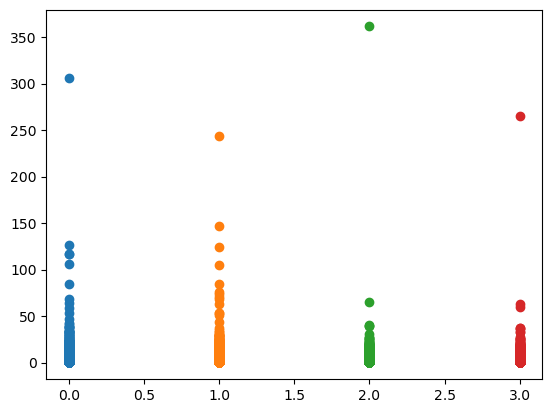

In [88]:
plt.plot(np.zeros(len(ef_data)), ef_data,'o')
plt.plot(np.ones(len(er_data))*1, er_data,'o')
plt.plot(np.ones(len(hlf_data))*2, hlf_data,'o')
plt.plot(np.ones(len(hlr_data))*3, hlr_data,'o')

In [13]:
group1 = ef_data
group2 = er_data
group3 = hlf_data
group4 = hlr_data

# Test for normality using Shapiro-Wilk test
shapiro_stat_group1, shapiro_p_value_group1 = stats.shapiro(group1)
shapiro_stat_group2, shapiro_p_value_group2 = stats.shapiro(group2)
shapiro_stat_group3, shapiro_p_value_group3 = stats.shapiro(group3)
shapiro_stat_group4, shapiro_p_value_group4 = stats.shapiro(group4)

print("Shapiro-Wilk test results:")
print(f"Group 1: Test Statistic = {shapiro_stat_group1}, p-value = {shapiro_p_value_group1}")
print(f"Group 2: Test Statistic = {shapiro_stat_group2}, p-value = {shapiro_p_value_group2}")
print(f"Group 3: Test Statistic = {shapiro_stat_group3}, p-value = {shapiro_p_value_group3}")
print(f"Group 4: Test Statistic = {shapiro_stat_group4}, p-value = {shapiro_p_value_group4}")


if all(p > 0.05 for p in [shapiro_p_value_group1, shapiro_p_value_group2, shapiro_p_value_group3, shapiro_p_value_group4]):
    # Perform ANOVA
    f_statistic, anova_p_value = stats.f_oneway(group1, group2, group3, group4)
    print("\nANOVA results:")
    print(f"F-statistic = {f_statistic}, p-value = {anova_p_value}")
else:
    # Perform Kruskal-Wallis test
    kruskal_stat, kruskal_p_value = stats.kruskal(ef_data, er_data, hlf_data, hlr_data)
    print("\nKruskal-Wallis test results:")
    print(f"Test Statistic = {kruskal_stat}, p-value = {kruskal_p_value}")


    
####################
print('----------------------------')

from scikit_posthocs import posthoc_dunn

# Perform Dunn's test
dunn_results = posthoc_dunn([group1, group2, group3, group4])

# Print the results
print("\nDunn's test post hoc test results:")
print(dunn_results)

Shapiro-Wilk test results:
Group 1: Test Statistic = 0.3013575077056885, p-value = 0.0
Group 2: Test Statistic = 0.3372573256492615, p-value = 0.0
Group 3: Test Statistic = 0.16090917587280273, p-value = 0.0
Group 4: Test Statistic = 0.22506123781204224, p-value = 0.0

Kruskal-Wallis test results:
Test Statistic = 137.23179826148044, p-value = 1.493797978465515e-29
----------------------------

Dunn's test post hoc test results:
              1             2             3             4
1  1.000000e+00  4.179562e-01  1.055709e-19  1.163411e-16
2  4.179562e-01  1.000000e+00  1.634600e-15  1.842256e-13
3  1.055709e-19  1.634600e-15  1.000000e+00  8.572310e-01
4  1.163411e-16  1.842256e-13  8.572310e-01  1.000000e+00


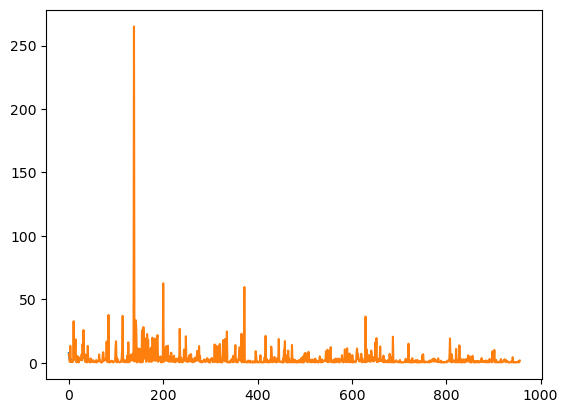

In [64]:
plt.plot(hlf_data)
plt.plot(hlr_data)

In [109]:
feature_results

[(0,
  'control_forwards',
  'control_reverse',
  method name               PERMANOVA
  test statistic name        pseudo-F
  sample size                      34
  number of groups                  2
  test statistic             0.165122
  p-value                         1.0
  number of permutations          999
  Name: PERMANOVA results, dtype: object),
 (0,
  'control_forwards',
  'lesion_forwards',
  method name               PERMANOVA
  test statistic name        pseudo-F
  sample size                      26
  number of groups                  2
  test statistic             3.858734
  p-value                         1.0
  number of permutations          999
  Name: PERMANOVA results, dtype: object),
 (0,
  'control_forwards',
  'lesion_reverse',
  method name               PERMANOVA
  test statistic name        pseudo-F
  sample size                      26
  number of groups                  2
  test statistic              4.70788
  p-value                         1.0
  number of

In [44]:
ef_data
er_data
hlf_data
hlr_data
lf_data
lr_data

[2.692133775258454,
 2.2175117435190947,
 5.958119614100602,
 1.2929898901908865,
 1.762338797060709,
 0.731730525327532,
 0.2353638669612772,
 0.9389433556497364,
 1.6089351363723072,
 4.577772568871882,
 0.472922042420581,
 0.3172282373048535,
 1.4559585713400365,
 1.363788805604953,
 0.3798575824498739,
 0.9926391721468264,
 0.6552323093794258,
 0.2061595784987948,
 1.167719009161276,
 2.914865357722842,
 0.4084334288965864,
 2.347979464127367,
 1.290613274889102,
 0.3132739942250758,
 0.745712044963654,
 4.211236051166844,
 0.541657477496111,
 0.7161266473547616,
 1.523789004302842,
 0.5816397565221637,
 1.1623752735407011,
 0.6959059946876989,
 0.7421496751464622,
 1.018565575551162,
 3.5125847300641664,
 0.3176673056831435,
 0.3243337214912759,
 2.30418983941834,
 1.25581673601457,
 3.325731879894892,
 1.5392247639153696,
 1.4921490895026344,
 0.9277482144384112,
 12.812069758469075,
 1.115469556120762,
 14.848487305889828,
 0.9628709369641952,
 0.3538652430716036,
 2.04853256224

In [45]:
hlf_data

[2.2008373503583334,
 0.3760942380248689,
 0.4009791746925534,
 0.589940116758464,
 6.00334269404882,
 0.928032474797427,
 0.2295500980503663,
 3.087654459015849,
 3.3326044663232763,
 17.68058369782305,
 1.5655846068390755,
 18.539434643515705,
 0.7675387266922241,
 2.6489693560977488,
 0.6988771408343103,
 22.41590128896016,
 24.157718919177125,
 19.172500706254844,
 40.19800049114784,
 0.264022494735329,
 0.4728587338964622,
 1.6597689755528326,
 6.372528969261515,
 2.9793764197907726,
 16.73347866200425,
 16.447466245998054,
 10.363168349934782,
 3.634848920460077,
 22.418044672202026,
 27.99453939645511,
 1.0257509688307522,
 5.1761357852308825,
 16.56781300314118,
 14.307627579285848,
 2.7776850847701184,
 1.2021307532983447,
 2.969247389438059,
 5.359907617027258,
 2.1943043606155586,
 4.173838902871305,
 1.94216390122448,
 1.5793714067868332,
 38.98458422629607,
 6.235622507082273,
 17.812616393467696,
 1.0097079386327503,
 4.383174155186861,
 30.69037238179905,
 4.300415137217

In [677]:
e_f_warp_factors
e_r_warp_factors
hl_f_warp_factors
hl_r_warp_factors

[[0.0,
  0.2764227642276423,
  0.24390243902439024,
  0.21138211382113822,
  0.13821138211382114,
  0.07317073170731707,
  0.032520325203252036,
  0.024390243902439025],
 [0.0,
  0.25555555555555554,
  0.2388888888888889,
  0.22777777777777777,
  0.125,
  0.07777777777777778,
  0.06388888888888888,
  0.011111111111111112],
 [0.0,
  0.42857142857142855,
  0.2857142857142857,
  0.2857142857142857,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.27586206896551724,
  0.13793103448275862,
  0.3448275862068966,
  0.1724137931034483,
  0.06896551724137931,
  0.0,
  0.0],
 [0.0,
  0.26666666666666666,
  0.4666666666666667,
  0.2,
  0.06666666666666667,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.26436781609195403,
  0.2988505747126437,
  0.2413793103448276,
  0.10344827586206896,
  0.09195402298850575,
  0.0,
  0.0],
 [0.0,
  0.3472222222222222,
  0.3333333333333333,
  0.1875,
  0.0763888888888889,
  0.020833333333333332,
  0.027777777777777776,
  0.006944444444444444],
 [0.0,
  0.3779527559055118,
  0.307086614

In [667]:
ef_data
hlf_data

[2.2008373503583334,
 0.3760942380248689,
 0.4009791746925534,
 0.589940116758464,
 6.00334269404882,
 0.928032474797427,
 0.2295500980503663,
 3.087654459015849,
 3.3326044663232763,
 17.68058369782305,
 1.5655846068390755,
 18.539434643515705,
 0.7675387266922241,
 2.6489693560977488,
 0.6988771408343103,
 22.41590128896016,
 24.157718919177125,
 19.172500706254844,
 40.19800049114784,
 0.264022494735329,
 0.4728587338964622,
 1.6597689755528326,
 6.372528969261515,
 2.9793764197907726,
 16.73347866200425,
 16.447466245998054,
 10.363168349934782,
 3.634848920460077,
 22.418044672202026,
 27.99453939645511,
 1.0257509688307522,
 5.1761357852308825,
 16.56781300314118,
 14.307627579285848,
 2.7776850847701184,
 1.2021307532983447,
 2.969247389438059,
 5.359907617027258,
 2.1943043606155586,
 4.173838902871305,
 1.94216390122448,
 1.5793714067868332,
 38.98458422629607,
 6.235622507082273,
 17.812616393467696,
 1.0097079386327503,
 4.383174155186861,
 30.69037238179905,
 4.300415137217

In [673]:
statistic, p_value = mannwhitneyu(ef_data, hlf_data)

In [675]:
len(ef_data)

3026

In [103]:
# def remove_outliers_z_score(x, y, threshold=3):
#     z_scores = np.abs((y - np.mean(y)) / np.std(y))
#     filtered_indices = z_scores <= threshold
#     return x[filtered_indices], y[filtered_indices]

# fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(15, 5))

# # filtered_x, filtered_y = remove_outliers_z_score(awake_involvements,sleep_involvements)
# filtered_x, filtered_y = remove_outliers_z_score(e_motif_involvements_awake, e_motif_involvements_sleep)

# sns.regplot(x=filtered_x,y=filtered_y, ax = ax)
# ax.set_xlabel('neuron awake motif involvement')
# ax.set_ylabel('neuron sleep motif involvement')
# ax.set_title('all motifs')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax.text(-0.2,-0.2,'r =' + str(r) )
# ax.text(-0.2,-0.3,'p =' + str(p) )

# ####################

# awake_involvements = task_motif_involvements_df.task_motif_involvements_awake.values
# sleep_involvements = task_motif_involvements_df.task_motif_involvements_sleep.values

# sns.regplot(x=awake_involvements,y=sleep_involvements, ax = ax2)
# ax2.set_xlabel('neuron awake motif involvement')
# ax2.set_ylabel('neuron sleep motif involvement')
# ax2.set_title('task related motifs')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax2.text(-0.2,-0.2,'r =' + str(r) )
# ax2.text(-0.2,-0.3,'p =' + str(p) )

# ####################

# awake_involvements = nontask_motif_involvements_df.nontask_motif_involvements_awake.values
# sleep_involvements = nontask_motif_involvements_df.nontask_motif_involvements_sleep.values

# sns.regplot(x=awake_involvements,y=sleep_involvements, ax = ax3)
# ax3.set_xlabel('neuron awake motif involvement')
# ax3.set_ylabel('neuron sleep motif involvement')
# ax3.set_title('non task related motifs')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax3.text(-0.2,-0.2,'r =' + str(r) )
# ax3.text(-0.2,-0.3,'p =' + str(p) )


# SaveFig('single_neuron_motif_involvements.png',out_path)

In [104]:

# ## add involved neurons:
# for index, item in enumerate(mean_norm_neuron_motif_involvements):
#     if item > 0:
#         if mean_norm_neuron_replay_involvements[index] > 0:
#             motif_involvements_awake += [item]
#             motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#             if seq_type in np.load(current_data_path+'task_order_seqs.npy')+1:
#                 task_motif_involvements_awake += [item]
#                 task_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]
#             else:
#                 nontask_motif_involvements_awake += [item]
#                 nontask_motif_involvements_sleep += [mean_norm_neuron_replay_involvements[index]]

In [105]:
# fig, [ax,ax2,ax3]= plt.subplots(1, 3,figsize=(15, 5))

# awake_involvements = reward_related_all_motif_involvements_df.reward_related_motif_involvements_awake.values
# sleep_involvements = reward_related_all_motif_involvements_df.reward_related_motif_involvements_sleep.values

# sns.regplot(x=awake_involvements,y=sleep_involvements, ax = ax)
# ax.set_xlabel('neuron awake motif involvement')
# ax.set_ylabel('neuron sleep motif involvement')
# ax.set_title('all motifs (reward related times)')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax.text(-0.2,-0.2,'r =' + str(r) )
# ax.text(-0.2,-0.3,'p =' + str(p) )

# ####################

# awake_involvements = reward_related_task_motif_involvements_df.reward_related_task_motif_involvements_awake.values
# sleep_involvements = reward_related_task_motif_involvements_df.reward_related_task_motif_involvements_sleep.values

# sns.regplot(x=awake_involvements,y=sleep_involvements, ax = ax2)
# ax2.set_xlabel('neuron awake motif involvement')
# ax2.set_ylabel('neuron sleep motif involvement')
# ax2.set_title('task related motifs (reward related times)')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax2.text(-0.2,-0.2,'r =' + str(r) )
# ax2.text(-0.2,-0.3,'p =' + str(p) )

# ####################

# awake_involvements = reward_related_nontask_motif_involvements_df.reward_related_nontask_motif_involvements_awake.values
# sleep_involvements = reward_related_nontask_motif_involvements_df.reward_related_nontask_motif_involvements_sleep.values

# sns.regplot(x=awake_involvements,y=sleep_involvements, ax = ax3)
# ax3.set_xlabel('neuron awake motif involvement')
# ax3.set_ylabel('neuron sleep motif involvement')
# ax3.set_title('non task related motifs (reward related times)')

# r, p = scipy .stats.pearsonr(awake_involvements,sleep_involvements)

# print(p)
# ax3.text(-0.2,-0.2,'r =' + str(r) )
# ax3.text(-0.2,-0.3,'p =' + str(p) )


# SaveFig('REWARD_RELATED_single_neuron_motif_involvements.png',out_path)

ValueError: min() arg is an empty sequence

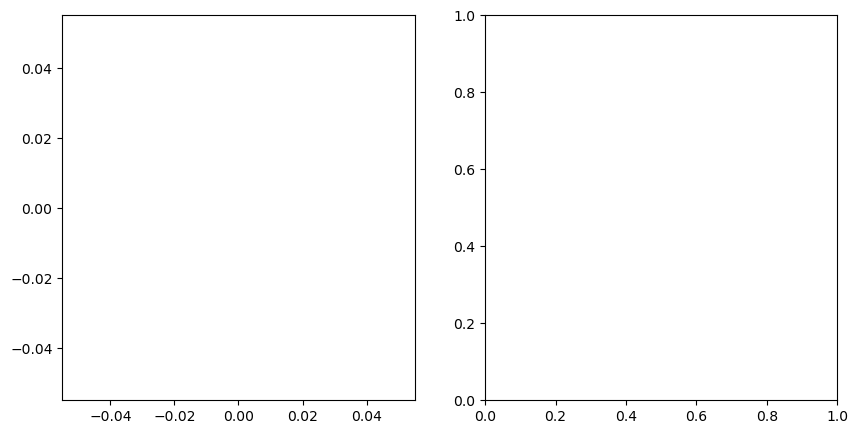

In [21]:
red = '#BE575F'
blue = '#2093C0'

t_temporally_ordered_means = []
t_stationary_means = []
t_not_ordered_means = []
n_temporally_ordered_means = []
n_stationary_means = []
n_not_ordered_means = []
task_groups = []

c_t_temporally_ordered_means = []
c_t_stationary_means = []
c_t_not_ordered_means = []
c_n_temporally_ordered_means = []
c_n_stationary_means = []
c_n_not_ordered_means = []
c_task_groups = []
for mouse, group in temporally_ordered_proportions.groupby('mouse'):
    if mouse in expert_mice:
        task_group = group[group.task_involved == 1]
        task_groups += [1]
        t_temporally_ordered_means += [np.mean(task_group.temporally_ordered)]
        t_stationary_means += [np.mean(task_group.stationary)]
        t_not_ordered_means += [np.mean(task_group.not_ordered)]

        nontask_group = group[group.task_involved == 0]
        n_temporally_ordered_means += [np.mean(nontask_group.temporally_ordered)]
        n_stationary_means += [np.mean(nontask_group.stationary)]
        n_not_ordered_means += [np.mean(nontask_group.not_ordered)]
    else:
        c_task_group = group[group.task_involved == 1]
        c_task_groups += [1]
        c_t_temporally_ordered_means += [np.mean(c_task_group.temporally_ordered)]
        c_t_stationary_means += [np.mean(c_task_group.stationary)]
        c_t_not_ordered_means += [np.mean(c_task_group.not_ordered)]

        c_nontask_group = group[group.task_involved == 0]
        c_n_temporally_ordered_means += [np.mean(c_nontask_group.temporally_ordered)]
        c_n_stationary_means += [np.mean(c_nontask_group.stationary)]
        c_n_not_ordered_means += [np.mean(c_nontask_group.not_ordered)]


fig, [ax,ax2],= plt.subplots(1, 2,figsize=(10, 5))
ax.plot(len(t_temporally_ordered_means)*[0.3]+len(t_stationary_means)*[1.3]+len(t_not_ordered_means)*[2.3],t_temporally_ordered_means+t_stationary_means+t_not_ordered_means,'o', c = red,alpha = 0.7,markeredgewidth = 0, markersize = 8)

ax.plot(len(c_t_temporally_ordered_means)*[3.3]+len(c_t_stationary_means)*[4.3]+len(c_t_not_ordered_means)*[5.3],c_t_temporally_ordered_means+c_t_stationary_means+c_t_not_ordered_means,'o', c = blue,alpha = 0.7,markeredgewidth = 0, markersize = 8)

groups =  len(t_temporally_ordered_means)*['to']+len(t_stationary_means)*['s']+len(t_not_ordered_means)*['co'] + len(c_t_temporally_ordered_means)*['cto']+len(c_t_stationary_means)*['cs']+len(c_t_not_ordered_means)*['o']
dat =  t_temporally_ordered_means+t_stationary_means+t_not_ordered_means+c_t_temporally_ordered_means+c_t_stationary_means+c_t_not_ordered_means

plt_df = pd.DataFrame({'task realted':groups,'proportion': dat })
ax=sns.boxplot( y = 'proportion', x = 'task realted', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

labels = ['late learning temporally ordered','late learning stationary','late learning fragmented','early learning temporally ordered','early learning stationary','early learning fragmented']

ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylim(0,1)

# ax2.plot(len(n_temporally_ordered_means)*[0.3]+len(n_stationary_means)*[1.3]+len(n_not_ordered_means)*[2.3],n_temporally_ordered_means+n_stationary_means+n_not_ordered_means,'o', color = 'red')

# ax2.plot(len(c_n_temporally_ordered_means)*[3.3]+len(c_n_stationary_means)*[4.3]+len(c_n_not_ordered_means)*[5.3],c_n_temporally_ordered_means+c_n_stationary_means+c_n_not_ordered_means,'o', color = 'blue')

# groups =  len(n_temporally_ordered_means)*['to']+len(n_stationary_means)*['s']+len(n_not_ordered_means)*['co'] + len(c_n_temporally_ordered_means)*['cto']+len(c_n_stationary_means)*['cs']+len(c_n_not_ordered_means)*['o']
# dat =  n_temporally_ordered_means+n_stationary_means+n_not_ordered_means+c_n_temporally_ordered_means+c_n_stationary_means+c_n_not_ordered_means

# plt_df = pd.DataFrame({'task realted':groups,'proportion': dat })
# ax=sns.boxplot( y = 'proportion', x = 'task realted', data = plt_df, color = 'blue', width = .2, zorder = 10,\
#             showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
#             showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
#                saturation = 1, orient = 'v',ax = ax2)

# labels = ['late learning temporally ordered','late learning stationary','late learning fragmented','early learning temporally ordered','early learning stationary','early learning fragmented']

# ax2.set_xticks(range(0,len(labels)))
# ax2.set_xticklabels(labels, rotation=90)
# ax2.set_ylim(0,1)


SaveFig('proportion_event_types.pdf',out_path)

In [107]:
e_mean_distances = []
e_task_mean_distances = []
e_nontask_mean_distances = []

c_mean_distances = []
c_task_mean_distances = []
c_nontask_mean_distances = []

all_chunk_diffs = []
all_chunk_dists = []

for mouse,group in regression_df.groupby('mouse'):
    task_chunk_dists = []
    nontask_chunk_dists = []
    chunk_dists = []
    for diff, chunk in group.groupby('sleep_onset_diff'):
        regression_line = chunk.regression_line.values
        distance = []
        task_distance = []
        nontask_distance = []
        for index in range(len(regression_line)):
            # Extract numeric values from the string using regular expression
            current_line = convert_string_array_to_list(regression_line[index])
            
            if np.max(current_line) > 1:
                max_ = 1
            else:
                max_ = np.max(current_line)
            if np.min(current_line) < 0:
                min_ = 0
            else:
                min_ = np.min(current_line)
            distance += [max_ - min_]
            if chunk.task_involved[index] == 1:
                task_distance += [max_ - min_]
            elif chunk.task_involved[index] == 0:
                nontask_distance += [max_ - min_]
                
                
        all_chunk_diffs += [diff]
        all_chunk_dists += [np.mean(distance)]
        chunk_dists += [np.mean(distance)]
        task_chunk_dists += [np.mean(task_distance)]
        nontask_chunk_dists += [np.mean(nontask_distance)]
        
    if mouse in expert_mice:
        e_mean_distances += [np.mean(chunk_dists)]
        e_task_mean_distances += [np.mean(task_chunk_dists)]
        e_nontask_mean_distances += [np.mean(nontask_chunk_dists)]
    else:
        c_mean_distances += [np.mean(chunk_dists)]
        c_task_mean_distances += [np.mean(task_chunk_dists)]
        c_nontask_mean_distances += [np.mean(nontask_chunk_dists)]
        

C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Emmett\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


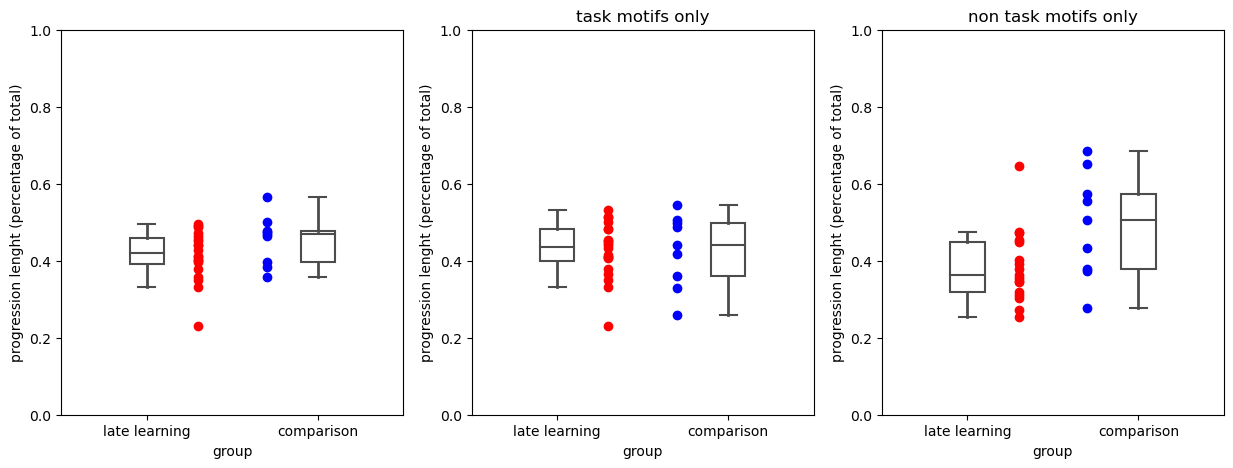

In [108]:
##### PLOT #########
        
        
fig,[ax,ax2,ax3] = plt.subplots(1, 3,figsize=(15, 5))

ax.plot(np.ones(len(e_mean_distances))*0.3,np.array(e_mean_distances),'o', color= 'red')

ax.plot(np.ones(len(c_mean_distances))*0.7,np.array(c_mean_distances),'o', color= 'blue')

groups =  ['late learning'] * len(e_mean_distances) +  ['comparison'] * len(c_mean_distances)
dat =  e_mean_distances + c_mean_distances

plt_df = pd.DataFrame({'group':groups,'motif proportion replayed': dat })
ax=sns.boxplot( y = 'motif proportion replayed', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylabel('progression lenght (percentage of total)')


ax.set_ylim(0,1)

#####################

ax2.plot(np.ones(len(e_task_mean_distances))*0.3,np.array(e_task_mean_distances),'o', color= 'red')

ax2.plot(np.ones(len(c_task_mean_distances))*0.7,np.array(c_task_mean_distances),'o', color= 'blue')


groups =  ['late learning'] * len(e_task_mean_distances) +  ['comparison'] * len(c_task_mean_distances)
dat =  e_task_mean_distances + c_task_mean_distances

plt_df = pd.DataFrame({'group':groups,'motif proportion replayed': dat })
ax2=sns.boxplot( y = 'motif proportion replayed', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax2)

ax2.set_ylabel('progression lenght (percentage of total)')


ax2.set_ylim(0,1)

ax2.set_title('task motifs only')

####################

ax3.plot(np.ones(len(e_nontask_mean_distances))*0.3,np.array(e_nontask_mean_distances),'o', color= 'red')

ax3.plot(np.ones(len(c_nontask_mean_distances))*0.7,np.array(c_nontask_mean_distances),'o', color= 'blue')


groups =  ['late learning'] * len(e_nontask_mean_distances) +  ['comparison'] * len(c_nontask_mean_distances)
dat =  e_nontask_mean_distances + c_nontask_mean_distances

plt_df = pd.DataFrame({'group':groups,'motif proportion replayed': dat })
ax3=sns.boxplot( y = 'motif proportion replayed', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax3)

ax3.set_ylabel('progression lenght (percentage of total)')


ax3.set_ylim(0,1)

ax3.set_title('non task motifs only')


SaveFig('progression_length.png',out_path)


In [109]:



# ax2.set_ylim(0,1)
# ax3.set_ylim(0,1)

# SaveFig('length_replayed.png',out_path)


# fig, ax= plt.subplots(1, 1,figsize=(5, 5))


# sns.regplot(y=all_chunk_dists,x=all_chunk_diffs, ax = ax)
# ax.set_xlabel('time from sleep onset')
# ax.set_ylabel('proportion motifs replayed')
# ax.set_title('amount of motif replayed vs time')

# r, p = scipy .stats.pearsonr(all_chunk_dists,all_chunk_diffs)

# print(p)
# ax.text(-0.1,-0.1,'r =' + str(r) )
# ax.text(-0.2,-0.2,'p =' + str(p) )


# SaveFig('length_replayed_vs_time.png',out_path)

In [22]:
e_all_chunk_forward_start_mean = []
e_all_chunk_forward_end_mean = []
e_all_chunk_reverse_start_mean = []
e_all_chunk_reverse_end_mean = []
c_all_chunk_forward_start_mean = []
c_all_chunk_forward_end_mean = []
c_all_chunk_reverse_start_mean = []
c_all_chunk_reverse_end_mean = []
# s_o_d = []
for mouse,group in start_end_df.groupby('mouse'):
    chunk_forward_start_mean = []
    chunk_forward_end_mean = []
    chunk_reverse_start_mean = []
    chunk_reverse_end_mean = []
    for diff, chunk in group.groupby('sleep_onset_diff'):
        forward_chunk = chunk[chunk.label == 'forward']
        chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
        chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

        reverse_chunk = chunk[chunk.label == 'reverse']
        chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
        chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]

#         s_o_d += [sleep_onset_diff]
        
    if mouse in expert_mice:
        e_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        e_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        e_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        e_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]
    else:
        c_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        c_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        c_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        c_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]



fig,[ax,ax2] = plt.subplots(1, 2,figsize=(10, 5))

## plot forward start and ends

ax.plot(np.array(e_all_chunk_reverse_start_mean),np.ones(len(e_all_chunk_reverse_start_mean))*0.3,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax.plot(np.array(e_all_chunk_reverse_end_mean),np.ones(len(e_all_chunk_reverse_end_mean))*0.7,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax.plot(np.array(c_all_chunk_reverse_start_mean),np.ones(len(c_all_chunk_reverse_start_mean))*2.3,'o', color = blue, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax.plot(np.array(c_all_chunk_reverse_end_mean),np.ones(len(c_all_chunk_reverse_end_mean))*2.7,'o', color = blue, alpha = 0.5,markeredgewidth = 0, markersize = 8)


groups =  ['starts'] * len(e_all_chunk_reverse_start_mean) + (['ends'] * len(e_all_chunk_reverse_end_mean)) + ['c_starts'] * len(c_all_chunk_reverse_start_mean) + (['c_ends'] * len(c_all_chunk_reverse_end_mean))
data =  e_all_chunk_reverse_start_mean +e_all_chunk_reverse_end_mean+c_all_chunk_reverse_start_mean +c_all_chunk_reverse_end_mean

if len(data) > 0:
    forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
    ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                   saturation = 1, orient = 'h',ax = ax)
    ax.set_xlabel('realtive start point')
    ax.set_title('reverse')

ax.set_xlim(0,100)
    
###########


ax2.plot(np.array(e_all_chunk_forward_start_mean),np.ones(len(e_all_chunk_forward_start_mean))*0.3,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax2.plot(np.array(e_all_chunk_forward_end_mean),np.ones(len(e_all_chunk_forward_end_mean))*0.7,'o', color = red, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax2.plot(np.array(c_all_chunk_forward_start_mean),np.ones(len(c_all_chunk_forward_start_mean))*2.3,'o', color = blue, alpha = 0.5,markeredgewidth = 0, markersize = 8)

ax2.plot(np.array(c_all_chunk_forward_end_mean),np.ones(len(c_all_chunk_forward_end_mean))*2.7,'o', color = blue, alpha = 0.5,markeredgewidth = 0, markersize = 8)


groups =  ['starts'] * len(e_all_chunk_forward_start_mean) + (['ends'] * len(e_all_chunk_forward_end_mean)) + ['c_starts'] * len(c_all_chunk_forward_start_mean) + (['c_ends'] * len(c_all_chunk_forward_end_mean))
data =  e_all_chunk_forward_start_mean +e_all_chunk_forward_end_mean+c_all_chunk_forward_start_mean +c_all_chunk_forward_end_mean

if len(data) > 0:
    forward_plt_df = pd.DataFrame({'group':groups,'distances (%)': data })
    ax=sns.boxplot( x = 'distances (%)', y = 'group', data = forward_plt_df, color = 'blue', width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
                showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
                   saturation = 1, orient = 'h',ax = ax2)

    
    ax2.set_xlabel('realtive start point')
    ax2.set_title('forward')
    

ax2.set_xlim(0,100)
    

SaveFig('start_end_points.pdf',out_path)

KeyError: 'mouse'

In [111]:
# fig,ax = plt.subplots(1, 1,figsize=(10, 5))

# warp_factors = regression_df.warp_factor.values

# import numpy as np
# import matplotlib.pyplot as plt
# from collections import Counter

# # Define the bin edges
# ### 40x 30x 20x 10x 5x 2x 1x 2x 5x 10x 20x 30x 40x
# # bin_edges = [0.025, 0.033, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 30 ,40]
# bin_edges = [0, 0.05, 0.2, 1, 5, 20, 999999]
# bin_labels = ['.025x & slower','.05:0.2x','.2-1x','1-5x','5-20x','20x & faster']

# # Sample data
# data = np.array(warp_factor)[np.array(warp_factor) > 0]

# # Bin the data and handle values outside the bins
# bin_indices = np.digitize(data, bin_edges)

# # Count the occurrences of each bin index
# bin_counts = Counter(bin_indices)

# # Get the number of bins (including the "other" bin)
# num_bins = len(bin_edges)

# # Create a list to store the counts for each bin
# bin_occurrences = [bin_counts[i] for i in range(1, num_bins)]

# # Set the vertical labels
# ax.set_xticks(range(len(bin_labels)))
# ax.set_xticklabels(bin_labels, rotation=90)

# # Plot the histogram
# ax.bar(bin_labels, bin_occurrences)
# ax.set_xlabel('Bins')
# ax.set_ylabel('Occurrences')
# ax.set_title('warp factors')


# ##### plot reverse warps
# # Sample data
# data = np.array(warp_factor)[np.array(warp_factor) < 0]
# bin_edges = [0, -0.05, -0.2, -1,-5, -20, -999999]
# # Bin the data and handle values outside the bins
# bin_indices = np.digitize(data, bin_edges)

# # Count the occurrences of each bin index
# bin_counts = Counter(bin_indices)

# # Get the number of bins (including the "other" bin)
# num_bins = len(bin_edges)

# # Create a list to store the counts for each bin
# bin_occurrences = [bin_counts[i] for i in range(1, num_bins)]
# # Plot the histogram
# ax.bar(bin_labels, bin_occurrences, alpha = 0.5)

# warp_factor = regression_df.warp_factor.values

# SaveFig('warp_factors.png',out_path)

In [112]:
def find_closest_example(numbers, examples):
    # Initialize dictionaries to store the closest example and example totals
    closest_examples = {}
    example_totals = {example: 0 for example in examples}

    # Iterate over each number in the list
    for number in numbers:
        # Initialize a variable to keep track of the closest example
        closest_example = None
        min_distance = float('inf')  # Initialize the minimum distance to infinity

        # Compare the number with each example
        for example in examples:
            # Calculate the absolute difference between the number and example
            distance = abs(number - example)

            # Check if the current example is closer than the previous closest example
            if distance < min_distance:
                min_distance = distance
                closest_example = example

        # Update the closest example for the current number in the dictionary
        closest_examples[number] = closest_example

        # Increment the total count for the closest example
        example_totals[closest_example] += 1

    return closest_examples, example_totals

def relative_warp_values(e_f_warp_factors):
    rels = []
    for item in e_f_warp_factors:
        rels += [list(np.array(item)/sum(item))]
    return rels

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

e_f_warp_factors = []
e_r_warp_factors = []
c_f_warp_factors = []
c_r_warp_factors = []

e_forward = []
e_reverse = []
c_forward = []
c_reverse = []

for mouse, group in regression_df.groupby('mouse'):
    if mouse in expert_mice:

        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_f_warp_factors +=[list(example_totals.values())]
        e_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_r_warp_factors +=[list(example_totals.values())]
        e_reverse += [sum(example_totals.values())]
    else:
        print(mouse)
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        closest_examples,example_totals = find_closest_example(data,bins_)
        c_f_warp_factors +=[list(example_totals.values())]
        c_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        closest_examples,example_totals = find_closest_example(data,bins_)
        c_r_warp_factors +=[list(example_totals.values())]
        c_reverse += [sum(example_totals.values())]
        
e_f_warp_factors = relative_warp_values(e_f_warp_factors)
e_r_warp_factors = relative_warp_values(e_r_warp_factors)
c_f_warp_factors = relative_warp_values(c_f_warp_factors)
c_r_warp_factors = relative_warp_values(c_r_warp_factors)



255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6


In [113]:
fr_props =[]
for i in range(len(e_forward)):
    fr_props += [e_forward[i] / (e_forward[i]+ e_reverse[i])]
np.mean(fr_props)

0.5688664994077512

In [114]:
fr_props =[]
for i in range(len(c_forward)):
    fr_props += [c_forward[i] / (c_forward[i]+ c_reverse[i])]
np.mean(fr_props)

0.592851354630638

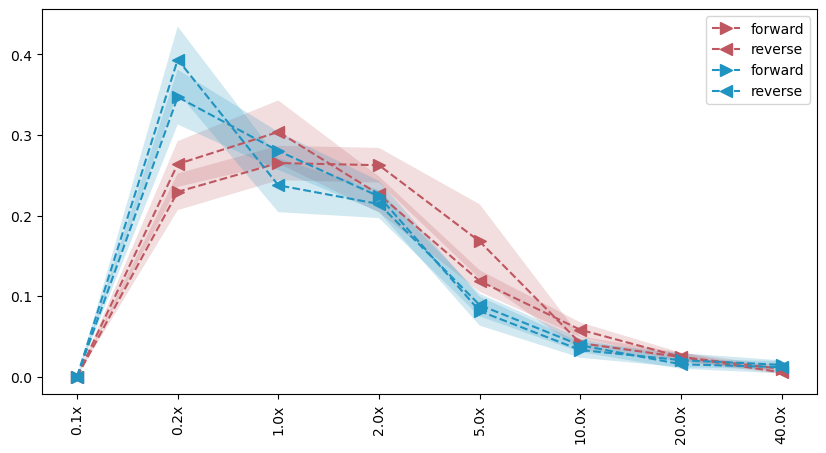

In [115]:

    
fig,ax = plt.subplots(1, 1,figsize=(10, 5))

bin_labels = [item + 'x' for item in np.array(bins_).astype(str)]

means = []
sems = []
for item in conactinate_nth_items(e_f_warp_factors):
    means += [np.mean(item)]
    sems += [scipy.stats.sem(item)]
ax.plot(means,'-->', color = red, markersize = 8, label = 'forward')
upper = np.array(means)+ sems
lower = np.array(means)- sems
ax.fill_between((range(len(bin_labels))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=red,
    linewidth=1, linestyle='dashdot', antialiased=True)

means = []
sems = []
for item in conactinate_nth_items(e_r_warp_factors):
    means += [np.mean(item)]
    sems += [scipy.stats.sem(item)]
ax.plot(means,'--<', color = red, markersize = 8,label = 'reverse')
upper = np.array(means)+ sems
lower = np.array(means)- sems
ax.fill_between((range(len(bin_labels))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=red,
    linewidth=1, linestyle='dashdot', antialiased=True)


means = []
sems = []
for item in conactinate_nth_items(c_f_warp_factors):
    means += [np.mean(item)]
    sems += [scipy.stats.sem(item)]
ax.plot(means,'-->', color = blue, markersize = 8, label = 'forward')
upper = np.array(means)+ sems
lower = np.array(means)- sems
ax.fill_between((range(len(bin_labels))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)

means = []
sems = []
for item in conactinate_nth_items(c_r_warp_factors):
    means += [np.mean(item)]
    sems += [scipy.stats.sem(item)]
ax.plot(means,'--<', color = blue, markersize = 8,label = 'reverse')
upper = np.array(means)+ sems
lower = np.array(means)- sems
ax.fill_between((range(len(bin_labels))),(lower),(upper),
    alpha=0.2, edgecolor='None', facecolor=blue,
    linewidth=1, linestyle='dashdot', antialiased=True)




# Set the vertical labels
ax.set_xticks(range(len(bin_labels)))
ax.set_xticklabels(bin_labels, rotation=90)

ax.legend()

SaveFig('warp_factors.pdf',out_path)


In [116]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA

# Example data for two groups (replace these with your actual data)
group1_data = conactinate_nth_items(e_f_warp_factors)

group2_data = conactinate_nth_items(c_f_warp_factors)

variable_names = bin_labels  # Add more variable names as needed

# Convert the list of lists to a DataFrame

vars_1 = []
vars_2 = []
for i, variable in enumerate(variable_names):
    vars_1 += len(group1_data[i]) * [variable]
    vars_2 += len(group2_data[i]) * [variable]

groups = ["Group1"] * len([item for sublist in group1_data for item in sublist]) + ["Group2"] * len([item for sublist in group2_data for item in sublist])

df = pd.DataFrame({'data':[item for sublist in group1_data for item in sublist] + [item for sublist in group2_data for item in sublist], 'flavour':vars_1+vars_2, 'group':groups })

In [117]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp

# Kruskal-Wallis test
grouped_data = [group['data'] for name, group in df.groupby('group')]
kruskal_result = kruskal(*grouped_data)

print("Kruskal-Wallis Result:")
print("H-statistic:", kruskal_result.statistic)
print("p-value:", kruskal_result.pvalue)



Kruskal-Wallis Result:
H-statistic: 0.025296301178956475
p-value: 0.8736309702036426


In [632]:
grouped_data

NameError: name 'grouped_data' is not defined

In [122]:
import numpy as np
from scipy import stats

# Step 1: Check for Normal Distribution
def check_normality(data):
    _, p_value = stats.shapiro(data)
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Data is not normally distributed.")
        var = False
    else:
        print("Data seems to be normally distributed.")
        var = True
    return var

# Step 2: Perform Statistical Test
def perform_statistical_test(data1, data2, var):
    if var == 1:
        _, p_value = stats.ttest_ind(data1, data2, equal_var=False)  # Welch's t-test
        print('ind t test')
    else:
        _, p_value = stats.mannwhitneyu(data1, data2, alternative="two-sided")
        print('mwu')
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("The two sets of data are significantly different.")
        print(p_value)
    else:
        print("-")
    



In [123]:
for i in range(len(conactinate_nth_items(c_f_warp_factors))):
    print('-------------')
    print(i)
    var1 = check_normality(conactinate_nth_items(c_f_warp_factors)[i])
    var2 = check_normality(conactinate_nth_items(e_f_warp_factors)[i])
    perform_statistical_test(conactinate_nth_items(c_f_warp_factors)[i], conactinate_nth_items(e_f_warp_factors)[i],var1 * var2)


-------------
0
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
1
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
The two sets of data are significantly different.
0.011393901178484557
-------------
2
Data seems to be normally distributed.
Data is not normally distributed.
mwu
-
-------------
3
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
4
Data seems to be normally distributed.
Data is not normally distributed.
mwu
-
-------------
5
Data seems to be normally distributed.
Data is not normally distributed.
mwu
-
-------------
6
Data is not normally distributed.
Data is not normally distributed.
mwu
-
-------------
7
Data is not normally distributed.
Data is not normally distributed.
mwu
-


C:\Users\Emmett\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [125]:
for i in range(len(conactinate_nth_items(c_r_warp_factors))):
    print('-------------')
    print(i)
    var1 = check_normality(conactinate_nth_items(c_r_warp_factors)[i])
    var2 = check_normality(conactinate_nth_items(e_r_warp_factors)[i])
    perform_statistical_test(conactinate_nth_items(c_r_warp_factors)[i], conactinate_nth_items(e_r_warp_factors)[i],var1 * var2)

-------------
0
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
1
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
The two sets of data are significantly different.
0.019369257146838712
-------------
2
Data seems to be normally distributed.
Data is not normally distributed.
mwu
-
-------------
3
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
4
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
5
Data seems to be normally distributed.
Data seems to be normally distributed.
ind t test
-
-------------
6
Data seems to be normally distributed.
Data is not normally distributed.
mwu
-
-------------
7
Data is not normally distributed.
Data is not normally distributed.
mwu
-


In [127]:

e_r_warp_factors

[[0.0,
  0.2072936660268714,
  0.2476007677543186,
  0.22840690978886757,
  0.16698656429942418,
  0.09213051823416507,
  0.04798464491362764,
  0.009596928982725527],
 [0.0,
  0.13846153846153847,
  0.2282051282051282,
  0.2205128205128205,
  0.20256410256410257,
  0.14615384615384616,
  0.05641025641025641,
  0.007692307692307693],
 [0.0,
  0.3010752688172043,
  0.3548387096774194,
  0.17204301075268819,
  0.11827956989247312,
  0.053763440860215055,
  0.0,
  0.0],
 [0.0,
  0.15753424657534246,
  0.23515981735159816,
  0.2191780821917808,
  0.16210045662100456,
  0.11187214611872145,
  0.0776255707762557,
  0.0365296803652968],
 [0.0,
  0.33527696793002915,
  0.282798833819242,
  0.2478134110787172,
  0.05539358600583091,
  0.061224489795918366,
  0.014577259475218658,
  0.0029154518950437317],
 [0.0,
  0.2358490566037736,
  0.3113207547169811,
  0.16981132075471697,
  0.22641509433962265,
  0.02830188679245283,
  0.02830188679245283,
  0.0],
 [0.0,
  0.16517857142857142,
  0.1964285

In [126]:
c_r_warp_factors

[[0.0,
  0.32460732984293195,
  0.193717277486911,
  0.225130890052356,
  0.12041884816753927,
  0.05759162303664921,
  0.041884816753926704,
  0.03664921465968586],
 [0.0,
  0.36929460580912865,
  0.2157676348547718,
  0.2033195020746888,
  0.1037344398340249,
  0.06639004149377593,
  0.03734439834024896,
  0.004149377593360996],
 [0.0,
  0.1891891891891892,
  0.4594594594594595,
  0.24324324324324326,
  0.05405405405405406,
  0.02702702702702703,
  0.02702702702702703,
  0.0],
 [0.0,
  0.3225806451612903,
  0.12903225806451613,
  0.3225806451612903,
  0.12903225806451613,
  0.03225806451612903,
  0.0,
  0.06451612903225806],
 [0.0,
  0.4444444444444444,
  0.2777777777777778,
  0.2222222222222222,
  0.05555555555555555,
  0.0,
  0.0,
  0.0],
 [0.0,
  0.36065573770491804,
  0.19672131147540983,
  0.18032786885245902,
  0.16393442622950818,
  0.08196721311475409,
  0.01639344262295082,
  0.0],
 [0.0,
  0.4642857142857143,
  0.22023809523809523,
  0.21428571428571427,
  0.077380952380952

In [120]:
True * True

1